In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 21.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from datasets import load_dataset, concatenate_datasets, Dataset
import numpy as np
from tqdm.notebook import tqdm
import json
import requests
import concurrent.futures
import os
import re

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
category_mappings = {
    "raw_meta_Clothing_Shoes_and_Jewelry": "Fashion",
    "raw_meta_Grocery_and_Gourmet_Food": "Grocery",
    "raw_meta_Electronics": "Electronics",
    "raw_meta_Home_and_Kitchen": "Home",
    "raw_meta_Beauty_and_Personal_Care": "Beauty"
}

category_records_dict = {
    "Fashion": 10000,
    "Grocery": 10500,
    "Electronics": 13000,
    "Home": 12000,
    "Beauty": 13000
}

In [ ]:
def clean_data(category_mappings, category_records_dict):
    all_data = []

    # Process each category
    for raw_meta_name, category_label in tqdm(category_mappings.items(), desc="Processing categories"):

        records_to_sample = category_records_dict[category_label]

        # Load streaming dataset
        streaming_ds = load_dataset(
            "McAuley-Lab/Amazon-Reviews-2023",
            raw_meta_name,
            streaming=True,
            trust_remote_code=True
            )

        # Extract required number of records
        category_data = []
        # for i, record in enumerate(tqdm(streaming_ds["full"], desc=f"Loading {category_label} data")):
        #     if i >= records_to_sample:
        #         break
        #     category_data.append(record)
        for record in tqdm(streaming_ds["full"].take(records_to_sample), desc=f"Loading {category_label} data", total=records_to_sample):
            category_data.append(record)

        # Convert to DataFrame
        df = pd.DataFrame(category_data)

        # Change category label
        df['main_category'] = category_label

        # Add match column (all 1 initially as these are legitimate pairs)
        df['is_match'] = 1

        # Add to combined dataset
        all_data.append(df)

    # Combine all categories
    combined_df = pd.concat(all_data, ignore_index=True)

    # Select only relevant columns
    cols_to_keep = ['main_category', 'title', 'categories', 'features', 'description', 'details', 'images', 'is_match']
    filtered_df = combined_df[cols_to_keep].copy()

    # Process image URLs - extract ONLY hi_res URL if valid
    def extract_first_image_url(images_data):
        try:
            if isinstance(images_data, str):
                try:
                    images_data = json.loads(images_data)
                except:
                    return None

            if not isinstance(images_data, dict):
                return None

            # Only extract from hi_res
            if 'hi_res' in images_data:
                hi_res_urls = images_data['hi_res']
                if (isinstance(hi_res_urls, list) and
                    len(hi_res_urls) > 0 and
                    hi_res_urls[0] is not None and
                    isinstance(hi_res_urls[0], str) and
                    hi_res_urls[0].startswith('http')):
                    return hi_res_urls[0]

            return None
        except:
            return None

    # Apply the image extraction function
    filtered_df['image_url'] = filtered_df['images'].apply(lambda x: extract_first_image_url(x))

    # Check if a value has substantial content
    def has_substantial_content(x):
        # Handle None values
        if x is None:
            return False

        # Check for empty structures
        if isinstance(x, (list, dict)) and len(x) == 0:
            return False

        # For lists, check if they contain substantial values
        if isinstance(x, list):
            return len(x) > 0 and any(isinstance(item, str) and len(str(item).strip()) > 3 for item in x)

        # For dictionaries, check if they contain substantial values
        if isinstance(x, dict):
            return len(x) > 0 and any(len(str(v).strip()) > 3 for k, v in x.items())

        # For strings, check if they're not empty
        if isinstance(x, str):
            return len(x.strip()) > 3

        # Other values are considered substantial
        return True

    # Get all columns to check (all columns except 'images' which we'll drop)
    required_cols = [col for col in filtered_df.columns if col != 'images']

    # Create individual mask for each column to check values length
    masks = {}
    for col in required_cols:
        if col == 'image_url':
            # For image_url column, check if it's None, NaN, or not a valid URL
            masks[col] = filtered_df[col].notna() & filtered_df[col].apply(lambda x: isinstance(x, str) and x.startswith('http'))
        elif col == 'main_category' or col == 'is_match':
            # These are expected to be non-empty and set by our code
            masks[col] = pd.Series([True] * len(filtered_df))
        else:
            # For all other columns, check for substantial content
            masks[col] = filtered_df[col].apply(has_substantial_content)

    # Count and report empty values
    for col in required_cols:
        empty_count = (~masks[col]).sum()
        print(f"Column '{col}' has {empty_count} empty or insubstantial values")

    # Combine all masks to filter the dataframe (keep only rows where ALL columns have valid data)
    final_mask = pd.Series([True] * len(filtered_df))
    for col, mask in masks.items():
        if col not in ['main_category', 'is_match']:  # Skip the ones we don't want to check
            final_mask = final_mask & mask

    # Apply the final mask
    filtered_df = filtered_df.loc[final_mask].copy()

    # Drop the original images column and keep only image_url
    filtered_df.drop('images', axis=1, inplace=True)

    # Reset index
    filtered_df.reset_index(drop=True, inplace=True)

    print(f"Final dataset shape: {filtered_df.shape}")
    print(f"Records per category:")
    print(filtered_df['main_category'].value_counts())

    return filtered_df

In [ ]:
filtered_df = clean_data(category_mappings, category_records_dict)

Processing categories:   0%|          | 0/5 [00:00<?, ?it/s]

Loading Fashion data:   0%|          | 0/10000 [00:00<?, ?it/s]

Loading Grocery data:   0%|          | 0/10500 [00:00<?, ?it/s]

Loading Electronics data:   0%|          | 0/13000 [00:00<?, ?it/s]

Loading Home data:   0%|          | 0/12000 [00:00<?, ?it/s]

Loading Beauty data:   0%|          | 0/13000 [00:00<?, ?it/s]

Column 'main_category' has 0 empty or insubstantial values
Column 'title' has 7 empty or insubstantial values
Column 'categories' has 2831 empty or insubstantial values
Column 'features' has 10524 empty or insubstantial values
Column 'description' has 25499 empty or insubstantial values
Column 'details' has 169 empty or insubstantial values
Column 'is_match' has 0 empty or insubstantial values
Column 'image_url' has 8453 empty or insubstantial values
Final dataset shape: (25660, 8)
Records per category:
main_category
Beauty         5200
Electronics    5192
Home           5127
Grocery        5102
Fashion        5039
Name: count, dtype: int64


In [ ]:
# Download images via url save in google drive
base_folder = '/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/images'
os.makedirs(base_folder, exist_ok=True)

# Download function with verification
def download_image(args):
    i, url, category = args
    try:
        # Create category folder
        category_folder = os.path.join(base_folder, category)
        os.makedirs(category_folder, exist_ok=True)

        # Extract file name
        try:
            file_name = os.path.basename(url).split('?')[0]
            if not file_name or '.' not in file_name:
                file_name = f"image_{i}.jpg"
        except:
            file_name = f"image_{i}.jpg"

        # Construct the save path
        save_path = os.path.join(category_folder, file_name)

        # Check if the file already exists and if its size is reasonable
        if os.path.exists(save_path) and os.path.getsize(save_path) > 1000:
            return (True, i, save_path, "Already exists")

        # Create a session
        session = requests.Session()
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept': 'image/avif,image/webp,image/apng,image/svg+xml,image/*,*/*;q=0.8',
            'Accept-Encoding': 'gzip, deflate, br',
            'Connection': 'keep-alive',
            'Referer': 'https://www.amazon.com/'
        }

        response = session.get(url, headers=headers, timeout=(3.05, 27), stream=True)

        if response.status_code == 200:
            # Download the file
            with open(save_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)

            # Verify the size of the downloaded file
            if os.path.getsize(save_path) < 1000:
                return (False, i, f"File too small: {os.path.getsize(save_path)} bytes")

            return (True, i, save_path, "Downloaded")
        else:
            return (False, i, f"Status code: {response.status_code}")
    except Exception as e:
        return (False, i, str(e))

# Main download function
def batch_download(dataframe, max_workers=10, retry_count=2):
    """
    Batch download images and store them by main_category
    """
    # Check for duplicate URLs
    total_rows = len(dataframe)
    unique_urls = dataframe['image_url'].nunique()
    if total_rows != unique_urls:
        print(f"Warning: Found {total_rows - unique_urls} duplicate URLs in the dataset")

    # Prepare the task list
    tasks = []
    for i, row in dataframe.iterrows():
        if pd.notna(row['image_url']) and row['image_url'].strip() != '':
            tasks.append((i, row['image_url'], row['main_category']))
        else:
            print(f"Skipping row {i}: Missing or empty URL")

    print(f"Prepared {len(tasks)} valid download tasks out of {total_rows} rows")

    # Initialize counters
    successful_downloads = 0
    already_exists = 0
    failed_downloads = 0
    retry_queue = []

    # Use thread pool for concurrent downloading
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(download_image, tasks), total=len(tasks), desc="Downloading Images"))

    # Process the results
    for idx, result in enumerate(results):
        if len(result) == 4:  # New version returns 4 values
            success, i, info, status = result
        else:  # Compatibility with old version
            success, i, info = result
            status = "Unknown"

        if success:
            if status == "Already exists":
                already_exists += 1
            else:
                successful_downloads += 1
        else:
            retry_queue.append(tasks[idx])

    # Retry failed downloads
    retry_attempts = 0
    while retry_queue and retry_attempts < retry_count:
        retry_attempts += 1
        print(f"\nRetrying {len(retry_queue)} failed images, attempt {retry_attempts}...")

        retry_tasks = retry_queue
        retry_queue = []

        with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
            retry_results = list(tqdm(executor.map(download_image, retry_tasks),
                                      total=len(retry_tasks),
                                      desc=f"Retrying Downloads"))

        for idx, result in enumerate(retry_results):
            if len(result) == 4:
                success, i, info, status = result
            else:
                success, i, info = result
                status = "Unknown"

            if success:
                if status == "Already exists":
                    already_exists += 1
                else:
                    successful_downloads += 1
            else:
                retry_queue.append(retry_tasks[idx])

    # Calculate final failed count
    failed_downloads = len(retry_queue)

    # Print final results
    print("\n===== Download Summary =====")
    print(f"Total tasks: {len(tasks)}")
    print(f"Newly downloaded: {successful_downloads}")
    print(f"Already existed: {already_exists}")
    print(f"Failed: {failed_downloads}")
    print(f"Total available: {successful_downloads + already_exists}")
    print(f"Images have been saved to: {base_folder} (organized by category)")

    # Verify the number of saved images
    total_saved = 0
    print("\nVerifying files on disk:")
    for category in dataframe['main_category'].unique():
        category_path = os.path.join(base_folder, category)
        if os.path.exists(category_path):
            files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
            print(f"- {category}: {len(files)} files")
            total_saved += len(files)

    print(f"Total files on disk: {total_saved}")

    # Return the result statistics
    return {
        "newly_downloaded": successful_downloads,
        "already_existed": already_exists,
        "failed": failed_downloads,
        "total_available": successful_downloads + already_exists,
        "failed_indices": [t[0] for t in retry_queue]
    }

# Example usage:
result_stats = batch_download(filtered_df, max_workers=15, retry_count=3)

Prepared 25660 valid download tasks out of 25660 rows



===== Download Summary =====
Total tasks: 25660
Newly downloaded: 25598
Already existed: 62
Failed: 0
Total available: 25660
Images have been saved to: /content/drive/MyDrive/amazon_meta_data/images (organized by category)

Verifying files on disk:
- Fashion: 5038 files
- Grocery: 5089 files
- Electronics: 5154 files
- Home: 5122 files
- Beauty: 5195 files
Total files on disk: 25598


In [ ]:
def replace_urls_with_drive_paths(df):
    # Create a new column to store the Google Drive paths
    df['image_path'] = None

    # Define the base path
    base_path = '/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/images'

    # Check if the base path exists
    if not os.path.exists(base_path):
        print(f"Warning: The base path {base_path} does not exist!")
        return df

    # Get all unique main_category values and their corresponding folders
    categories = df['main_category'].unique()
    category_paths = {}
    category_files = {}

    print("Scanning category folders...")
    for category in categories:
        category_path = os.path.join(base_path, category)
        if os.path.exists(category_path):
            category_paths[category] = category_path
            # Get all the files in the category folder
            files = set(os.listdir(category_path))
            category_files[category] = files
            print(f"  • {category}: Found {len(files)} files")
        else:
            print(f"  • {category}: Folder does not exist")

    # Define the conversion function
    def convert_url_to_path(row):
        if pd.isna(row['image_url']) or not isinstance(row['image_url'], str):
            return None

        category = row['main_category']
        if category not in category_paths:
            return None

        # Extract the filename from the URL
        try:
            filename = row['image_url'].split('/')[-1].split('?')[0]

            # Check if the file exists
            if filename in category_files[category]:
                return os.path.join(category_paths[category], filename)
            else:
                return None
        except:
            return None

    # Apply the conversion
    print("Replacing URLs and validating file existence...")
    tqdm.pandas()
    df['image_path'] = df.progress_apply(convert_url_to_path, axis=1)

    # Statistics of the result
    total_rows = len(df)
    matched_rows = df['image_path'].notna().sum()

    print(f"\nProcess completed!")
    print(f"Total rows: {total_rows}")
    print(f"Successfully matched: {matched_rows} ({matched_rows/total_rows*100:.2f}%)")
    print(f"Unmatched: {total_rows - matched_rows} ({(total_rows - matched_rows)/total_rows*100:.2f}%)")

    # Category-wise match statistics
    print("\nCategory-wise matching statistics:")
    for category in categories:
        category_total = len(df[df['main_category'] == category])
        category_matched = len(df[(df['main_category'] == category) & df['image_path'].notna()])
        if category_total > 0:
            match_rate = category_matched / category_total * 100
            print(f"  • {category}: {category_matched}/{category_total} ({match_rate:.2f}%)")

    return df

filtered_df = replace_urls_with_drive_paths(filtered_df)

Scanning category folders...
  • Fashion: Found 5038 files
  • Grocery: Found 5089 files
  • Electronics: Found 5154 files
  • Home: Found 5122 files
  • Beauty: Found 5195 files
Replacing URLs and validating file existence...


  0%|          | 0/25660 [00:00<?, ?it/s]


Process completed!
Total rows: 25660
Successfully matched: 25660 (100.00%)
Unmatched: 0 (0.00%)

Category-wise matching statistics:
  • Fashion: 5039/5039 (100.00%)
  • Grocery: 5102/5102 (100.00%)
  • Electronics: 5192/5192 (100.00%)
  • Home: 5127/5127 (100.00%)
  • Beauty: 5200/5200 (100.00%)


In [ ]:
# Save df used images path to google drive
save_folder = '/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data'
os.makedirs(save_folder, exist_ok=True)

csv_path = os.path.join(save_folder, "filtered_data.csv")
filtered_df.to_csv(csv_path, index=False, encoding="utf-8")

parquet_path = os.path.join(save_folder, "filtered_data.parquet")
filtered_df.to_parquet(parquet_path, index=False)

In [ ]:
parquet_path = "/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/filtered_data.parquet"

filtered_df = pd.read_parquet(parquet_path)

In [ ]:
def process_single_image(row_data, output_base_dir, prefix, target_size):
    """
    Processes a single image.

    Arguments:
    row_data: Tuple containing (idx, image_path, main_category)
    output_base_dir: Directory to save the processed images
    prefix: Prefix for the processed image filename
    target_size: Desired image size to resize the image to

    Returns:
    idx: Index of the processed row
    processed_path: Path of the processed image if successful, None if failed
    """
    from PIL import Image
    import os
    import pandas as pd

    idx, image_path, main_category = row_data

    if pd.isna(image_path) or not os.path.exists(image_path):
        return idx, None

    try:
        # Get the original filename of the image
        original_filename = os.path.basename(image_path)

        # Construct the path for the processed image
        processed_filename = f"{prefix}{original_filename}"
        category_dir = os.path.join(output_base_dir, main_category)
        processed_path = os.path.join(category_dir, processed_filename)

        # Skip processing if the file already exists (useful for resuming interrupted processing)
        if os.path.exists(processed_path):
            return idx, processed_path

        # Open the image and process it
        img = Image.open(image_path).convert('RGB')
        img = img.resize(target_size)

        # Save the processed image
        img.save(processed_path)

        return idx, processed_path

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return idx, None


def preprocess_product_data(df, output_base_dir, prefix="processed_", target_size=(224, 224), n_jobs=-1):
    """
    Preprocesses product text and image data, storing images in directories organized by main_category.
    Adds a progress bar and parallel processing for improved speed.

    Arguments:
    df (pandas.DataFrame): DataFrame containing the product data
    output_base_dir (str): Directory to store processed images
    prefix (str): Prefix for the processed image filenames
    target_size (tuple): Desired size for the images (default is 224x224)
    n_jobs (int): Number of jobs for parallel processing. -1 uses all available processors

    Returns:
    pandas.DataFrame: DataFrame with added processed image paths
    """
    import os
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    from concurrent.futures import ProcessPoolExecutor, as_completed
    import multiprocessing
    import functools

    # Create a copy of the DataFrame to avoid modifying the original
    processed_df = df.copy()

    print("Processing text data...")
    # Text preprocessing (lowercase and remove non-alphanumeric characters)
    processed_df['title_processed'] = processed_df['title'].astype(str).str.lower().str.replace('[^\w\s]', ' ', regex=True)

    # Process other text columns
    processed_df['categories_text'] = processed_df['categories'].apply(
        lambda x: ' '.join(x) if isinstance(x, list) else str(x)
    )

    processed_df['features_text'] = processed_df['features'].apply(
        lambda x: ' '.join([item.split(': ')[1] if isinstance(item, str) and ': ' in item else str(item)
                           for item in x]) if isinstance(x, list) else str(x)
    )

    processed_df['description_text'] = processed_df['description'].apply(
        lambda x: ' '.join(x) if isinstance(x, list) else str(x)
    )

    processed_df['details_text'] = processed_df['details'].apply(
        lambda x: ' '.join([f"{k}: {v}" for k, v in x.items()])
                if isinstance(x, dict) else str(x)
    )

    # Combine all text fields into a single column
    processed_df['all_text'] = (
        '[TITLE] ' + processed_df['title_processed'] +
        ' [CAT] ' + processed_df['categories_text'] +
        ' [FEAT] ' + processed_df['features_text'] +
        ' [DESC] ' + processed_df['description_text'] +
        ' [DET] ' + processed_df['details_text']
    )

    print("Creating output directories...")
    # Create necessary directories for each category
    unique_categories = processed_df['main_category'].unique()
    for category in unique_categories:
        os.makedirs(os.path.join(output_base_dir, category), exist_ok=True)

    # Add a column for processed image paths
    processed_df['processed_image_path'] = None

    print("Processing images...")
    # Determine the number of workers for parallel processing if n_jobs is -1
    if n_jobs == -1:
        n_jobs = multiprocessing.cpu_count()

    # Prepare image data for parallel processing
    image_data = [(idx, row['image_path'], row['main_category'])
                  for idx, row in processed_df.iterrows()
                  if pd.notna(row['image_path'])]

    # Create a partial function to add the additional arguments for image processing
    process_func = functools.partial(
        process_single_image,
        output_base_dir=output_base_dir,
        prefix=prefix,
        target_size=target_size
    )

    # Parallel processing of images with progress bar
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        futures = [executor.submit(process_func, data) for data in image_data]

        # Progress bar to show image processing status
        with tqdm(total=len(futures), desc="Processing images") as pbar:
            for future in as_completed(futures):
                idx, processed_path = future.result()
                if processed_path:
                    processed_df.at[idx, 'processed_image_path'] = processed_path
                pbar.update(1)

    print("Processing complete!")
    return processed_df

In [ ]:
processed_images_path = "/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/processed_images"
processed_df = preprocess_product_data(filtered_df, processed_images_path)

处理文本数据...
创建输出目录...
处理图像...


处理图像: 100%|██████████| 25660/25660 [11:25<00:00, 37.44it/s]


处理完成!


In [ ]:
# Check numbers of processed images for each main_category
base_path = "/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/processed_images"

# Traverse all subfolders under base_path
folder_counts = {}
for root, dirs, files in os.walk(base_path):
    if root != base_path:
        folder_name = os.path.basename(root)
        folder_counts[folder_name] = len(files)

# Print the file count for each subfolder
for folder, count in folder_counts.items():
    print(f"{folder}: {count} files")

Fashion: 5038 files
Grocery: 5089 files
Electronics: 5154 files
Home: 5122 files
Beauty: 5195 files


In [ ]:
columns_to_keep = ["main_category", "all_text", "processed_image_path", "is_match"]
processed_df = processed_df.filter(items=columns_to_keep)

In [ ]:
save_folder = '/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data'
os.makedirs(save_folder, exist_ok=True)

csv_path = os.path.join(save_folder, "processed_data.csv")
processed_df.to_csv(csv_path, index=False, encoding="utf-8")

parquet_path = os.path.join(save_folder, "processed_data.parquet")
processed_df.to_parquet(parquet_path, index=False)

In [ ]:
# Load processed data
parquet_path = "/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/processed_data.parquet"

processed_df = pd.read_parquet(parquet_path)

In [ ]:
processed_df

,main_category,all_text,processed_image_path,is_match
0,Fashion,[TITLE] sas women s relaxed sandal [CAT] Clot...,/content/drive/MyDrive/amazon_meta_data/proces...,1
1,Fashion,[TITLE] michael kors cindy women s cross body...,/content/drive/MyDrive/amazon_meta_data/proces...,1
2,Fashion,[TITLE] dr scholl s shoes women s dawn it loa...,/content/drive/MyDrive/amazon_meta_data/proces...,1
3,Fashion,[TITLE] costume gloves kids girls boys princes...,/content/drive/MyDrive/amazon_meta_data/proces...,1
4,Fashion,[TITLE] chowsir women fashion v neck formal la...,/content/drive/MyDrive/amazon_meta_data/proces...,1
...,...,...,...,...
25655,Beauty,[TITLE] curve appeal by liz claiborne 1 oz eau...,/content/drive/MyDrive/amazon_meta_data/proces...,1
25656,Beauty,[TITLE] chevron make up cosmetic tote organize...,/content/drive/MyDrive/amazon_meta_data/proces...,1
25657,Beauty,[TITLE] ionic ceramic thermal brush foldable ...,/content/drive/MyDrive/amazon_meta_data/proces...,1
25658,Beauty,[TITLE] natural elephant exfoliating hammam gl...,/content/drive/MyDrive/amazon_meta_data/proces...,1


In [ ]:
import random

def generate_cross_category_samples(df):
    """
    Generate cross-category negative samples: Pair an image from one category with text from a different category.

    Arguments:
    df (pandas.DataFrame): The original data containing main_category, all_text, processed_image_path, and is_match columns.

    Returns:
    pandas.DataFrame: Cross-category negative samples.
    """
    negative_samples = []

    # Get all categories
    categories = df['main_category'].unique()

    # For each sample, create a cross-category negative sample
    for idx, row in df.iterrows():
        # Get the current sample's category
        current_category = row['main_category']

        # Get other categories that are different from the current category
        other_categories = [cat for cat in categories if cat != current_category]

        if other_categories:  # Ensure there are other categories to choose from
            # Randomly choose a different category
            target_category = random.choice(other_categories)

            # Randomly select a sample's text from the target category
            target_samples = df[df['main_category'] == target_category]

            if not target_samples.empty:
                target_row = target_samples.sample(1).iloc[0]

                # Create a negative sample: retain the original image, but use text from a different category
                negative_row = row.copy()
                negative_row['all_text'] = target_row['all_text']
                negative_row['is_match'] = 0  # Negative sample label
                negative_row['mismatch_type'] = 'cross_category'

                negative_samples.append(negative_row)

    return pd.DataFrame(negative_samples)

def generate_within_category_samples(df):
    """
    Generate within-category negative samples: Replace text with that of a different product within the same category.

    Arguments:
    df (pandas.DataFrame): The original data containing main_category, all_text, processed_image_path, and is_match columns.

    Returns:
    pandas.DataFrame: Within-category negative samples.
    """
    negative_samples = []

    # Group data by main_category
    category_groups = df.groupby('main_category')

    # For each sample, create a within-category negative sample
    for idx, row in df.iterrows():
        current_category = row['main_category']

        # Get all samples from the same category excluding the current sample
        same_category_samples = category_groups.get_group(current_category)
        other_samples = same_category_samples[same_category_samples.index != idx]

        if not other_samples.empty:
            # Randomly select a different product from the same category
            target_row = other_samples.sample(1).iloc[0]

            # Create a negative sample: retain the original image, but use text from a different product in same category
            negative_row = row.copy()
            negative_row['all_text'] = target_row['all_text']
            negative_row['is_match'] = 0  # Negative sample label
            negative_row['mismatch_type'] = 'within_category'

            negative_samples.append(negative_row)

    return pd.DataFrame(negative_samples)

def generate_color_mismatch_samples(df):
    """
    Generate color mismatch negative samples: Replace the description with text describing a completely different color.

    Arguments:
    df (pandas.DataFrame): The original data containing main_category, all_text, processed_image_path, and is_match columns.

    Returns:
    pandas.DataFrame: Color mismatch negative samples.
    """
    import re
    import random
    import pandas as pd

    # Common colors to detect and replace
    common_colors = [
        'red', 'blue', 'green', 'yellow', 'black', 'white', 'orange', 'purple',
        'pink', 'brown', 'gray', 'grey', 'silver', 'gold', 'teal', 'navy', 'maroon',
        'olive', 'violet', 'beige', 'coral', 'magenta', 'turquoise', 'indigo',
        'crimson', 'cyan', 'aqua', 'azure', 'lavender', 'ivory', 'khaki', 'tan'
    ]

    # Extended color options for replacement (can include more complex colors)
    replacement_colors = common_colors + [
        'burgundy', 'charcoal', 'emerald', 'mauve', 'mustard', 'plum', 'rust',
        'sage', 'salmon', 'slate', 'taupe', 'mint', 'ochre', 'peach', 'ruby',
        'sapphire', 'terracotta', 'amethyst', 'cobalt', 'chestnut'
    ]

    negative_samples = []

    # Pattern to match color words
    color_pattern = re.compile(r'\b(' + '|'.join(common_colors) + r')\b', re.IGNORECASE)

    # For each sample, try to create a color mismatch negative sample
    for idx, row in df.iterrows():
        text = row['all_text']

        # Find all color mentions
        color_matches = color_pattern.findall(text)

        if color_matches:  # Only proceed if colors are found
            # Create a copy of the row
            negative_row = row.copy()

            # Replace each color with a different random color
            modified_text = text
            for color in set(color_matches):  # Use set to handle repeated colors
                # Choose a different color for replacement
                replacement_options = [c for c in replacement_colors if c.lower() != color.lower()]
                replacement_color = random.choice(replacement_options)

                # Replace the color (case-insensitive)
                pattern = re.compile(r'\b' + re.escape(color) + r'\b', re.IGNORECASE)
                modified_text = pattern.sub(replacement_color, modified_text)

            # Update the text with color replacements
            negative_row['all_text'] = modified_text
            negative_row['is_match'] = 0  # Negative sample label
            negative_row['mismatch_type'] = 'color_mismatch'

            negative_samples.append(negative_row)

    return pd.DataFrame(negative_samples) if negative_samples else pd.DataFrame()

def generate_material_mismatch_samples(df):
    """
    Generate material mismatch negative samples: Keep product appearance similar, but change the material description in the text.

    Arguments:
    df (pandas.DataFrame): The original data containing main_category, all_text, processed_image_path columns.

    Returns:
    pandas.DataFrame: Material mismatch negative samples.
    """

    # Define high-frequency materials by category
    category_materials = {
        'Fashion': [
            'cotton', 'polyester', 'leather', 'denim', 'wool', 'silk', 'linen',
            'nylon', 'cashmere', 'suede', 'velvet', 'satin', 'lycra', 'spandex',
            'fleece', 'tweed', 'modal', 'rayon', 'viscose', 'corduroy', 'canvas',
            'chiffon', 'jersey', 'flannel', 'acrylic'
        ],
        'Home': [
            'wood', 'metal', 'plastic', 'glass', 'ceramic', 'steel', 'aluminum',
            'brass', 'marble', 'granite', 'porcelain', 'concrete', 'wicker', 'rattan',
            'bamboo', 'copper', 'iron', 'stainless steel', 'chrome', 'silicone',
            'microfiber', 'resin', 'plywood', 'foam', 'rubber', 'vinyl'
        ],
        'Electronics': [
            'plastic', 'metal', 'aluminum', 'glass', 'steel', 'rubber', 'silicone',
            'carbon fiber', 'copper', 'polymer', 'abs', 'chrome', 'titanium', 'pvc',
            'fiberglass', 'polycarbonate', 'ceramic', 'kevlar', 'lithium', 'nylon'
        ],
        'Beauty': [
            'plastic', 'glass', 'silicone', 'ceramic', 'bamboo', 'stainless steel',
            'shea butter', 'coconut oil', 'argan oil', 'jojoba oil', 'hyaluronic acid',
            'retinol', 'charcoal', 'clay', 'aloe vera', 'vitamin e', 'beeswax',
            'collagen', 'essential oils', 'vitamin c', 'natural extracts'
        ],
        'Grocery': [
            'plastic', 'glass', 'paper', 'cardboard', 'aluminum', 'tin', 'steel',
            'wheat', 'corn', 'rice', 'oats', 'soy', 'sugar', 'flour', 'chocolate',
            'dairy', 'vegetable', 'fruit', 'meat', 'poultry', 'fish', 'organic',
            'natural', 'whole grain', 'gluten free'
        ]
    }

    # Define semantic groups by category
    semantic_groups = {
        'Fashion': {
            'natural_fabrics': ['cotton', 'wool', 'silk', 'linen', 'cashmere', 'hemp'],
            'synthetic_fabrics': ['polyester', 'nylon', 'spandex', 'lycra', 'acrylic', 'rayon', 'viscose'],
            'animal_materials': ['leather', 'suede', 'fur', 'cashmere', 'wool'],
            'heavy_fabrics': ['denim', 'canvas', 'corduroy', 'tweed', 'flannel'],
            'light_fabrics': ['silk', 'chiffon', 'satin', 'lace']
        },
        'Home': {
            'metals': ['metal', 'steel', 'aluminum', 'brass', 'copper', 'iron', 'stainless steel', 'chrome'],
            'woods': ['wood', 'bamboo', 'plywood', 'oak', 'pine', 'maple', 'walnut'],
            'stones': ['marble', 'granite', 'concrete', 'stone', 'slate', 'quartz'],
            'natural_fibers': ['wicker', 'rattan', 'bamboo', 'jute', 'hemp'],
            'glass_ceramics': ['glass', 'ceramic', 'porcelain', 'crystal'],
            'synthetics': ['plastic', 'silicone', 'resin', 'foam', 'rubber', 'vinyl', 'acrylic']
        },
        'Electronics': {
            'common_plastics': ['plastic', 'abs', 'pvc', 'polycarbonate', 'polymer'],
            'premium_materials': ['aluminum', 'carbon fiber', 'titanium', 'kevlar', 'fiberglass'],
            'display_materials': ['glass', 'oled', 'lcd', 'gorilla glass', 'sapphire glass'],
            'metals': ['metal', 'steel', 'aluminum', 'copper', 'chrome']
        },
        'Beauty': {
            'packaging': ['plastic', 'glass', 'silicone', 'ceramic', 'bamboo', 'metal'],
            'natural_oils': ['coconut oil', 'argan oil', 'jojoba oil', 'vitamin e', 'olive oil', 'rosehip oil'],
            'active_ingredients': ['hyaluronic acid', 'retinol', 'vitamin c', 'collagen', 'niacinamide', 'salicylic acid'],
            'natural_ingredients': ['aloe vera', 'charcoal', 'clay', 'natural extracts', 'essential oils', 'beeswax']
        },
        'Grocery': {
            'packaging': ['plastic', 'glass', 'paper', 'cardboard', 'aluminum', 'tin', 'steel'],
            'grains': ['wheat', 'corn', 'rice', 'oats', 'barley', 'quinoa', 'whole grain'],
            'proteins': ['soy', 'meat', 'poultry', 'fish', 'eggs', 'beans', 'legumes'],
            'dietary_types': ['organic', 'natural', 'gluten free', 'vegan', 'non-gmo', 'raw']
        }
    }

    negative_samples = []
    category_counts = {cat: 0 for cat in category_materials.keys()}

    # Process each row
    for idx, row in df.iterrows():
        category = row['main_category']
        text = row['all_text']

        # Skip if category not in our defined lists
        if category not in category_materials:
            continue

        # Get materials for this category
        materials = category_materials[category]

        # Create pattern to find materials
        material_pattern = re.compile(r'\b(' + '|'.join(materials) + r')\b', re.IGNORECASE)

        # Find all material mentions
        material_matches = material_pattern.findall(text)

        if material_matches:  # Only proceed if materials are found
            # Create a copy of the row
            negative_row = row.copy()

            # Replace each material with a semantically different material
            modified_text = text

            # Track materials already replaced to maintain consistency
            replacement_map = {}

            for material in set(material_matches):  # Use set to handle repeated materials
                # If we've already decided on a replacement for this material, use it for consistency
                if material.lower() in replacement_map:
                    replacement_material = replacement_map[material.lower()]
                else:
                    # Find which semantic group this material belongs to
                    material_group = None
                    for group_name, group_materials in semantic_groups[category].items():
                        if material.lower() in [m.lower() for m in group_materials]:
                            material_group = group_name
                            break

                    # Choose a material from a different semantic group
                    replacement_options = []

                    if material_group:
                        # Get materials from different semantic groups
                        for group_name, group_materials in semantic_groups[category].items():
                            if group_name != material_group:
                                replacement_options.extend(group_materials)
                    else:
                        # If no semantic group found, just use different materials
                        replacement_options = [m for m in materials if m.lower() != material.lower()]

                    # If we have options after filtering, choose one
                    if replacement_options:
                        replacement_material = random.choice(replacement_options)
                    else:
                        # Fallback: just pick a different material
                        replacement_material = random.choice([m for m in materials if m.lower() != material.lower()])

                    # Store this replacement for consistency
                    replacement_map[material.lower()] = replacement_material

                # Replace the material (case-insensitive)
                pattern = re.compile(r'\b' + re.escape(material) + r'\b', re.IGNORECASE)
                modified_text = pattern.sub(replacement_material, modified_text)

            # Update the text with material replacements
            negative_row['all_text'] = modified_text
            negative_row['is_match'] = 0  # Negative sample label
            negative_row['mismatch_type'] = 'material_mismatch'

            negative_samples.append(negative_row)
            category_counts[category] += 1

    return pd.DataFrame(negative_samples) if negative_samples else pd.DataFrame()

def generate_all_negative_samples(df, proportions=None):
    """
    Generate all types of negative samples and merge them according to specified proportions.

    Arguments:
    df (pandas.DataFrame): The original data.
    proportions (dict, optional): The proportions of each negative sample type. Defaults to equal distribution.

    Returns:
    pandas.DataFrame: The merged DataFrame containing all negative samples.
    """
    if proportions is None:
        proportions = {
            'cross_category': 0.25,
            'within_category': 0.25,
            'color_mismatch': 0.25,
            'material_mismatch': 0.25
        }

    # Calculate the number of negative samples to generate for each type
    total_count = len(df)
    counts = {k: int(total_count * v) for k, v in proportions.items()}

    # Generate each type of negative sample
    cross_category = generate_cross_category_samples(df)
    within_category = generate_within_category_samples(df)
    color_mismatch = generate_color_mismatch_samples(df)
    material_mismatch = generate_material_mismatch_samples(df)

    # Sample and merge based on the required proportions
    all_negatives = pd.concat([
        cross_category.sample(counts['cross_category'], replace=len(cross_category) < counts['cross_category']),
        within_category.sample(counts['within_category'], replace=len(within_category) < counts['within_category']),
        color_mismatch.sample(counts['color_mismatch'], replace=len(color_mismatch) < counts['color_mismatch']),
        material_mismatch.sample(counts['material_mismatch'], replace=len(material_mismatch) < counts['material_mismatch'])
    ])

    # Shuffle the rows
    return all_negatives.sample(frac=1).reset_index(drop=True)


negative_df = generate_all_negative_samples(processed_df,
                                                 proportions={'cross_category': 0.2,
                                                             'within_category': 0.3,
                                                             'color_mismatch': 0.3,
                                                             'material_mismatch': 0.2})


Material mismatch samples distribution by category:
Fashion: 3661 samples (23.9%)
Home: 3579 samples (23.3%)
Electronics: 2379 samples (15.5%)
Beauty: 1664 samples (10.8%)
Grocery: 4060 samples (26.5%)


In [ ]:
save_folder = '/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data'
os.makedirs(save_folder, exist_ok=True)

csv_path = os.path.join(save_folder, "negative_data.csv")
negative_df.to_csv(csv_path, index=False, encoding="utf-8")

parquet_path = os.path.join(save_folder, "negative_data.parquet")
negative_df.to_parquet(parquet_path, index=False)

In [ ]:
# Load negative data
parquet_path = "/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/negative_data.parquet"

negative_df = pd.read_parquet(parquet_path)

In [ ]:
negative_df

,main_category,all_text,processed_image_path,is_match,mismatch_type
0,Home,[TITLE] ron s fish and tackle [CAT] Home & Kit...,/content/drive/MyDrive/amazon_meta_data/proces...,0,material_mismatch
1,Grocery,[TITLE] morningstar farms veggie burgers plan...,/content/drive/MyDrive/amazon_meta_data/proces...,0,material_mismatch
2,Home,[TITLE] banneton proofing basket for bread ris...,/content/drive/MyDrive/amazon_meta_data/proces...,0,material_mismatch
3,Beauty,[TITLE] country western nail art waterslide ...,/content/drive/MyDrive/amazon_meta_data/proces...,0,color_mismatch
4,Fashion,[TITLE] outre synthetic l part lace front wig ...,/content/drive/MyDrive/amazon_meta_data/proces...,0,cross_category
...,...,...,...,...,...
25655,Grocery,[TITLE] shufeal steampunk mechanical dog statu...,/content/drive/MyDrive/amazon_meta_data/proces...,0,cross_category
25656,Electronics,[TITLE] asus et2411inki b011k 23 6 inch all in...,/content/drive/MyDrive/amazon_meta_data/proces...,0,within_category
25657,Electronics,[TITLE] padwa lifestyle soft sleeve slim pouch...,/content/drive/MyDrive/amazon_meta_data/proces...,0,within_category
25658,Home,[TITLE] vickerman 8 5 camdon fir slim artific...,/content/drive/MyDrive/amazon_meta_data/proces...,0,material_mismatch


In [ ]:
def merge_positive_negative_samples(positive_df, negative_df):
    """
    Merge the positive and negative sample datasets.

    Parameters:
    positive_df (pandas.DataFrame): The positive sample dataset
    negative_df (pandas.DataFrame): The negative sample dataset

    Returns:
    pandas.DataFrame: The merged dataset
    """

    required_columns = ['main_category', 'all_text', 'processed_image_path', 'is_match']

    # Check the positive sample dataset
    for col in required_columns:
        if col not in positive_df.columns:
            raise ValueError(f"Positive sample dataset is missing the required column: {col}")

    # Check the negative sample dataset
    for col in required_columns:
        if col not in negative_df.columns:
            raise ValueError(f"Negative sample dataset is missing the required column: {col}")

    # Ensure the positive sample has the 'mismatch_type' column (set to None)
    if 'mismatch_type' not in positive_df.columns:
        positive_df = positive_df.copy()
        positive_df['mismatch_type'] = None

    # Merge the datasets
    combined_df = pd.concat([positive_df, negative_df], ignore_index=True)

    # Data quality checks
    print(f"Merged dataset size: {combined_df.shape}")
    print(f"Number of positive samples: {combined_df['is_match'].sum()}")
    print(f"Number of negative samples: {len(combined_df) - combined_df['is_match'].sum()}")

    return combined_df

combined_df = merge_positive_negative_samples(processed_df, negative_df)

Merged dataset size: (51320, 5)
Number of positive samples: 25660
Number of negative samples: 25660


In [ ]:
combined_df

,main_category,all_text,processed_image_path,is_match,mismatch_type
0,Fashion,[TITLE] sas women s relaxed sandal [CAT] Clot...,/content/drive/MyDrive/amazon_meta_data/proces...,1,None
1,Fashion,[TITLE] michael kors cindy women s cross body...,/content/drive/MyDrive/amazon_meta_data/proces...,1,None
2,Fashion,[TITLE] dr scholl s shoes women s dawn it loa...,/content/drive/MyDrive/amazon_meta_data/proces...,1,None
3,Fashion,[TITLE] costume gloves kids girls boys princes...,/content/drive/MyDrive/amazon_meta_data/proces...,1,None
4,Fashion,[TITLE] chowsir women fashion v neck formal la...,/content/drive/MyDrive/amazon_meta_data/proces...,1,None
...,...,...,...,...,...
51315,Grocery,[TITLE] shufeal steampunk mechanical dog statu...,/content/drive/MyDrive/amazon_meta_data/proces...,0,cross_category
51316,Electronics,[TITLE] asus et2411inki b011k 23 6 inch all in...,/content/drive/MyDrive/amazon_meta_data/proces...,0,within_category
51317,Electronics,[TITLE] padwa lifestyle soft sleeve slim pouch...,/content/drive/MyDrive/amazon_meta_data/proces...,0,within_category
51318,Home,[TITLE] vickerman 8 5 camdon fir slim artific...,/content/drive/MyDrive/amazon_meta_data/proces...,0,material_mismatch


In [ ]:
def preprocess_text_for_all_models(df, text_column='all_text'):
    """
    Preprocess the merged text data to make it suitable for all models.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the text data
    text_column (str): The column name that contains the text data

    Returns:
    pandas.DataFrame: DataFrame with added preprocessed text
    """
    import re
    import unicodedata

    # Create a copy of the DataFrame
    processed_df = df.copy()

    # Text normalization function
    def normalize_text(text):
        if not isinstance(text, str):
            return ""

        # Unicode normalization
        text = unicodedata.normalize('NFKC', text)

        # Replace multiple spaces with a single space
        text = re.sub(r'\s+', ' ', text)

        # Ensure there are spaces around tags
        for tag in ['[TITLE]', '[CAT]', '[FEAT]', '[DESC]', '[DET]']:
            text = text.replace(tag, f" {tag} ")

        # Clean extra spaces
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    # Clean and normalize the text
    processed_df['text_normalized'] = processed_df[text_column].apply(normalize_text)

    # Add text statistics features (helpful for analysis and filtering)
    processed_df['text_length'] = processed_df['text_normalized'].str.len()
    processed_df['word_count'] = processed_df['text_normalized'].str.split().str.len()

    # Extract structured features (for later model-specific processing)
    def extract_tag_content(text, tag_start, tag_end=None):
        if not isinstance(text, str):
            return ""

        if tag_end is None:
            # Find the next tag
            next_tags = ['[TITLE]', '[CAT]', '[FEAT]', '[DESC]', '[DET]']
            start_pos = text.find(tag_start)
            if start_pos == -1:
                return ""

            # Find the positions of the next tags
            end_positions = [text.find(tag, start_pos + len(tag_start)) for tag in next_tags if tag != tag_start]
            end_positions = [pos for pos in end_positions if pos > start_pos]

            if end_positions:
                end_pos = min(end_positions)
                return text[start_pos + len(tag_start):end_pos].strip()
            else:
                return text[start_pos + len(tag_start):].strip()
        else:
            # Directly find content between two tags
            start_pos = text.find(tag_start)
            if start_pos == -1:
                return ""

            end_pos = text.find(tag_end, start_pos + len(tag_start))
            if end_pos == -1:
                return text[start_pos + len(tag_start):].strip()

            return text[start_pos + len(tag_start):end_pos].strip()

    # Extract content from different parts (for model-specific use)
    processed_df['title_content'] = processed_df['text_normalized'].apply(
        lambda x: extract_tag_content(x, '[TITLE]'))
    processed_df['category_content'] = processed_df['text_normalized'].apply(
        lambda x: extract_tag_content(x, '[CAT]'))
    processed_df['features_content'] = processed_df['text_normalized'].apply(
        lambda x: extract_tag_content(x, '[FEAT]'))
    processed_df['description_content'] = processed_df['text_normalized'].apply(
        lambda x: extract_tag_content(x, '[DESC]'))
    processed_df['details_content'] = processed_df['text_normalized'].apply(
        lambda x: extract_tag_content(x, '[DET]'))

    # Create preprocessed fields for different types of models
    # 1. Simplified text for traditional ML (remove special tags)
    processed_df['text_for_tfidf'] = processed_df['text_normalized'].str.replace(
        r'\[(TITLE|CAT|FEAT|DESC|DET)\]', '', regex=True).str.strip()

    # 2. Text with preserved structure for deep learning models
    processed_df['text_for_deep'] = processed_df['text_normalized']

    # 3. Truncate overly long text (set a safe limit for models)
    max_length = 2048  # Sufficient for most models
    processed_df['text_for_tfidf'] = processed_df['text_for_tfidf'].apply(
        lambda x: x[:max_length] if len(x) > max_length else x)
    processed_df['text_for_deep'] = processed_df['text_for_deep'].apply(
        lambda x: x[:max_length] if len(x) > max_length else x)

    print(f"Text preprocessing completed: {processed_df.shape[0]} records")
    print(f"Text length statistics: Min={processed_df['text_length'].min()}, "
          f"Max={processed_df['text_length'].max()}, "
          f"Average={processed_df['text_length'].mean():.1f}")

    return processed_df

In [ ]:
preprocessed_df = preprocess_text_for_all_models(combined_df)

Text preprocessing completed: 51320 records
Text length statistics: Min=211, Max=19763, Average=1727.2


In [ ]:
preprocessed_df

,main_category,all_text,processed_image_path,is_match,mismatch_type,text_normalized,text_length,word_count,title_content,category_content,features_content,description_content,details_content,text_for_tfidf,text_for_deep
0,Fashion,[TITLE] sas women s relaxed sandal [CAT] Clot...,/content/drive/MyDrive/amazon_meta_data/proces...,1,None,[TITLE] sas women s relaxed sandal [CAT] Cloth...,1441,214,sas women s relaxed sandal,"Clothing, Shoes & Jewelry Women Shoes Sandals ...",Made in the USA Suede sole Heel measures appro...,"Unwind, leave your worries behind, and simply ...","{""Product Dimensions"": ""10 x 15 x 6 inches; 2 ...","sas women s relaxed sandal Clothing, Shoes & ...",[TITLE] sas women s relaxed sandal [CAT] Cloth...
1,Fashion,[TITLE] michael kors cindy women s cross body...,/content/drive/MyDrive/amazon_meta_data/proces...,1,None,[TITLE] michael kors cindy women s cross body ...,835,128,michael kors cindy women s cross body bag,"Clothing, Shoes & Jewelry Women Handbags & Wal...","Leather 9-1/2"" W x 5-1/4"" H x 2-1/4"" D Interio...","Adjustable crossbody strap with 24""-26"" drop T...","{""Is Discontinued By Manufacturer"": ""No"", ""Pro...",michael kors cindy women s cross body bag Clo...,[TITLE] michael kors cindy women s cross body ...
2,Fashion,[TITLE] dr scholl s shoes women s dawn it loa...,/content/drive/MyDrive/amazon_meta_data/proces...,1,None,[TITLE] dr scholl s shoes women s dawn it loaf...,952,137,dr scholl s shoes women s dawn it loafer,"Clothing, Shoes & Jewelry Women Shoes Loafers ...",Textile Imported Man Made sole Shaft measures ...,Breathable and on-trend knit fabrics give this...,"{""Item Weight"": ""8 Ounces"", ""Item model number...",dr scholl s shoes women s dawn it loafer Clot...,[TITLE] dr scholl s shoes women s dawn it loaf...
3,Fashion,[TITLE] costume gloves kids girls boys princes...,/content/drive/MyDrive/amazon_meta_data/proces...,1,None,[TITLE] costume gloves kids girls boys princes...,1778,255,costume gloves kids girls boys princess dress ...,"Clothing, Shoes & Jewelry Novelty & More Cloth...","Polyester,Spandex Pull On closure Do Not Bleac...",Universal gloves are suitable for boys and gir...,"{""Department"": ""boys"", ""Date First Available"":...",costume gloves kids girls boys princess dress ...,[TITLE] costume gloves kids girls boys princes...
4,Fashion,[TITLE] chowsir women fashion v neck formal la...,/content/drive/MyDrive/amazon_meta_data/proces...,1,None,[TITLE] chowsir women fashion v neck formal la...,1158,112,chowsir women fashion v neck formal lace eveni...,"Clothing, Shoes & Jewelry Women Clothing Dress...","Lace Zipper closure Made of Lace, soft and com...",Size Table: Chowsir Size-----General Size----U...,"{""Department"": ""womens"", ""Date First Available...",chowsir women fashion v neck formal lace eveni...,[TITLE] chowsir women fashion v neck formal la...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51315,Grocery,[TITLE] shufeal steampunk mechanical dog statu...,/content/drive/MyDrive/amazon_meta_data/proces...,0,cross_category,[TITLE] shufeal steampunk mechanical dog statu...,1816,270,shufeal steampunk mechanical dog statue indust...,Home & Kitchen Home Décor Products Home Décor ...,🌠The design concept of mechanical dog comes fr...,Product Description Name: Creative Punk Dog St...,"{""Brand"": ""SHUFEAL"", ""Color"": ""Silver"", ""Style...",shufeal steampunk mechanical dog statue indust...,[TITLE] shufeal steampunk mechanical dog statu...
51316,Electronics,[TITLE] asus et2411inki b011k 23 6 inch all in...,/content/drive/MyDrive/amazon_meta_data/proces...,0,within_category,[TITLE] asus et2411inki b011k 23 6 inch all in...,1994,283,asus et2411inki b011k 23 6 inch all in one des...,Electronics Computers & Accessories Computers ...,Intel Core i5-3450 Processor (3.1 GHz) 8 GB DD...,Product Description Featuring an entertainment...,"{""Standing screen display size"": ""23.6 Inches""...",asus et2411inki b011k 23 6 inch all in one des...,[TITLE] asus et2411in

In [ ]:
def prepare_for_stratified_split(df):
    """
    Prepare the stratification label column for stratified sampling, ensuring all categories and labels
    remain balanced during the split.
    """

    # Create a stratification label column
    df['strat_label'] = df['main_category'] + '_' + df['is_match'].astype(str)

    # For negative samples, include mismatch type
    if 'mismatch_type' in df.columns:
        neg_mask = df['is_match'] == 0
        df.loc[neg_mask, 'strat_label'] += '_' + df.loc[neg_mask, 'mismatch_type'].fillna('unknown').astype(str)

    # Output overall dataset statistics
    print("\nDataset Distribution Overview:")
    print(f"Total samples: {len(df)}")
    print(f"Positive samples: {df['is_match'].sum()} ({df['is_match'].mean()*100:.1f}%)")
    print(f"Negative samples: {len(df) - df['is_match'].sum()} ({(1-df['is_match'].mean())*100:.1f}%)")
    print(f"Number of product categories: {df['main_category'].nunique()}")
    print("\nProduct category distribution:")
    print(df['main_category'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

    if 'mismatch_type' in df.columns:
        print("\nMismatch type distribution (for negative samples):")
        mismatch_dist = df[df['is_match']==0]['mismatch_type'].value_counts(normalize=True).mul(100).round(1)
        print(mismatch_dist.astype(str) + '%')

    return df

preprocessed_df = prepare_for_stratified_split(preprocessed_df)


Dataset Distribution Overview:
Total samples: 51320
Positive samples: 25660 (50.0%)
Negative samples: 25660 (50.0%)
Number of product categories: 5

Product category distribution:
main_category
Home           21.3%
Electronics    20.6%
Grocery        19.7%
Beauty         19.5%
Fashion        19.0%
Name: proportion, dtype: object

Mismatch type distribution (for negative samples):
mismatch_type
color_mismatch       30.0%
within_category      30.0%
material_mismatch    20.0%
cross_category       20.0%
Name: proportion, dtype: object


In [ ]:
save_folder = '/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data'
os.makedirs(save_folder, exist_ok=True)

csv_path = os.path.join(save_folder, "preprocessed_data.csv")
preprocessed_df.to_csv(csv_path, index=False, encoding="utf-8")

parquet_path = os.path.join(save_folder, "preprocessed_data.parquet")
preprocessed_df.to_parquet(parquet_path, index=False)

In [ ]:
# Load preprocessed data
parquet_path = "/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/preprocessed_data.parquet"

preprocessed_df = pd.read_parquet(parquet_path)

# Split Dataset


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os

def split_dataset(df, output_dir=None, train_size=0.7, val_size=0.1, random_state=42):
    """
    Split the dataset into training, validation, and test sets.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing all the data
    output_dir (str): The directory to save the split datasets (if needed)
    train_size (float): The proportion of the dataset to be used for training, default is 0.7 (70%)
    val_size (float): The proportion of the dataset to be used for validation, default is 0.1 (10%)
    random_state (int): Random seed to ensure reproducibility

    Returns:
    tuple: (train_df, val_df, test_df) Three DataFrames representing the splits
    """
    # Calculate the test set size (default is 1 - train_size - val_size = 0.2)
    test_size = 1.0 - train_size - val_size

    # First split: training set vs (validation + test set)
    temp_size = val_size + test_size  # 0.3
    train_df, temp_df = train_test_split(
        df,
        test_size=temp_size,
        stratify=df['strat_label'],
        random_state=random_state
    )

    # Second split: validation set vs test set
    # val_size proportion in temp_df = 0.1 / 0.3 = 0.33...
    val_ratio = val_size / temp_size  # approximately 0.33

    val_df, test_df = train_test_split(
        temp_df,
        test_size=(1 - val_ratio),  # approximately 0.67
        stratify=temp_df['strat_label'],
        random_state=random_state
    )

    # Print the statistics of the splits
    print(f"Total dataset size: {len(df)}")
    print(f"Training set size: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
    print(f"Validation set size: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
    print(f"Test set size: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

    # Check the distribution of categories in each split
    print("\nCategory distribution in each dataset:")
    for name, dataset in [("Training set", train_df), ("Validation set", val_df), ("Test set", test_df)]:
        pos_ratio = dataset['is_match'].mean() * 100
        print(f"{name}: Positive samples {pos_ratio:.1f}%, Negative samples {100-pos_ratio:.1f}%")

    # If an output directory is provided, save the split datasets
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        train_df.to_csv(os.path.join(output_dir, 'train_data.csv'), index=False)
        train_df.to_parquet(os.path.join(output_dir, 'train_data.parquet'), index=False)

        val_df.to_csv(os.path.join(output_dir, 'val_data.csv'), index=False)
        val_df.to_parquet(os.path.join(output_dir, 'val_data.parquet'), index=False)

        test_df.to_csv(os.path.join(output_dir, 'test_data.csv'), index=False)
        test_df.to_parquet(os.path.join(output_dir, 'test_data.parquet'), index=False)

        print(f"\nDatasets have been saved to {output_dir}")

    return train_df, val_df, test_df


In [ ]:
# Split the dataset
train_df, val_df, test_df = split_dataset(
    df=preprocessed_df,
    output_dir='/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/split_data',
    random_state=42  # Ensure reproducibility
)

# Check the sizes of each part
print(f"Number of training samples: {len(train_df)}")
print(f"Number of validation samples: {len(val_df)}")
print(f"Number of test samples: {len(test_df)}")

# Check the distribution of specific categories in each part
for name, data in [("Training", train_df), ("Validation", val_df), ("Test", test_df)]:
    category_dist = data['main_category'].value_counts(normalize=True) * 100
    print(f"\n{name} set category distribution:")
    print(category_dist.round(1).astype(str) + '%')


Total dataset size: 51320
Training set size: 35923 (70.0%)
Validation set size: 5132 (10.0%)
Test set size: 10265 (20.0%)

Category distribution in each dataset:
Training set: Positive samples 50.0%, Negative samples 50.0%
Validation set: Positive samples 50.0%, Negative samples 50.0%
Test set: Positive samples 50.0%, Negative samples 50.0%

Datasets have been saved to /content/drive/MyDrive/amazon_meta_data/split_data
Number of training samples: 35923
Number of validation samples: 5132
Number of test samples: 10265

Training set category distribution:
main_category
Home           21.3%
Electronics    20.6%
Grocery        19.7%
Beauty         19.5%
Fashion        19.0%
Name: proportion, dtype: object

Validation set category distribution:
main_category
Home           21.3%
Electronics    20.6%
Grocery        19.7%
Beauty         19.5%
Fashion        19.0%
Name: proportion, dtype: object

Test set category distribution:
main_category
Home           21.3%
Electronics    20.6%
Grocery    

In [ ]:
# Load splited data
train_path = "/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/split_data/train_data.parquet"
val_path = '/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/split_data/val_data.parquet'
test_path = '/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/split_data/test_data.parquet'

train_df = pd.read_parquet(train_path)
val_df = pd.read_parquet(val_path)
test_df = pd.read_parquet(test_path)

# Decision Tree Ensemble Model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from skimage.feature import hog
from skimage import io, color, transform
from sklearn.decomposition import PCA
import cv2
from tqdm import tqdm
import joblib
import os
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing

def extract_image_features(image_path):
    """Extract HOG and color features from a single image"""
    try:
        # Read the image
        img = cv2.imread(image_path)
        if img is None:
            return None

        # Convert to RGB (OpenCV uses BGR by default)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 1. HOG features
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hog_features = hog(
            img_gray,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False
        )

        # 2. Color Histogram
        color_features = []
        for i in range(3):  # RGB channels
            hist = cv2.calcHist([img], [i], None, [32], [0, 256])
            color_features.extend(hist.flatten())

        # Combine all image features
        return np.concatenate([hog_features, np.array(color_features)])

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


def preprocess_for_tree_ensemble(train_df, val_df, test_df,
                                 text_column='text_for_tfidf',
                                 image_column='processed_image_path',
                                 output_dir='tree_ensemble_features',
                                 n_jobs=-1):
    """
    Extract and prepare features for decision tree ensemble model.

    Parameters:
    train_df, val_df, test_df: Splitted datasets
    text_column: Name of the column containing preprocessed text
    image_column: Name of the column containing image paths
    output_dir: Directory to save extracted features
    n_jobs: Number of jobs for parallel processing

    Returns:
    dict: Dictionary containing all features and vectorizers
    """
    if n_jobs == -1:
        n_jobs = multiprocessing.cpu_count()

    os.makedirs(output_dir, exist_ok=True)

    print("Preparing features for decision tree ensemble model...")

    # ==== 1. Text Feature Extraction ====
    print("\n1. Text Feature Extraction - TF-IDF")

    # Create TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,  # Limit the number of features to avoid dimensional explosion
        min_df=5,           # Appear in at least 5 documents
        max_df=0.85,        # Appear in no more than 85% of documents
        ngram_range=(1, 2)  # Use 1-gram and 2-gram
    )

    # Fit and transform on the training set
    print("  Fitting TF-IDF vectorizer...")
    X_text_train = tfidf_vectorizer.fit_transform(train_df[text_column])

    # Transform validation and test sets
    X_text_val = tfidf_vectorizer.transform(val_df[text_column])
    X_text_test = tfidf_vectorizer.transform(test_df[text_column])

    print(f"  Text feature shape: {X_text_train.shape[1]} dimensions")

    # Save the vectorizer
    joblib.dump(tfidf_vectorizer, os.path.join(output_dir, 'tfidf_vectorizer.pkl'))

    # ==== 2. Image Feature Extraction ====
    print("\n2. Image Feature Extraction - HOG and Color Histogram")

    # Parallel processing of image feature extraction
    def process_dataset_images(df):
        features = []
        valid_indices = []

        image_paths = df[image_column].tolist()

        with ProcessPoolExecutor(max_workers=n_jobs) as executor:
            futures = {executor.submit(extract_image_features, path): i
                      for i, path in enumerate(image_paths)}

            with tqdm(total=len(futures), desc="Extracting Image Features") as pbar:
                for future in as_completed(futures):
                    idx = futures[future]
                    result = future.result()
                    if result is not None:
                        features.append(result)
                        valid_indices.append(idx)
                    pbar.update(1)

        # Convert to numpy array
        if features:
            features_array = np.vstack(features)
            return features_array, valid_indices
        else:
            return np.array([]), []

    # Extract training set image features
    print("  Extracting training set image features...")
    X_img_train, train_valid_indices = process_dataset_images(train_df)

    # If valid image features exist
    if len(X_img_train) > 0:
        # Keep only valid image samples
        train_df_valid = train_df.iloc[train_valid_indices].reset_index(drop=True)
        X_text_train_valid = X_text_train[train_valid_indices]

        # Apply PCA on image features
        print("  Applying PCA on image features...")
        pca = PCA(n_components=min(300, X_img_train.shape[1], X_img_train.shape[0]),
                 random_state=42)
        X_img_train_pca = pca.fit_transform(X_img_train)
        joblib.dump(pca, os.path.join(output_dir, 'image_pca.pkl'))

        # Extract image features for validation and test sets
        print("  Extracting validation set image features...")
        X_img_val, val_valid_indices = process_dataset_images(val_df)
        if len(X_img_val) > 0:
            X_img_val_pca = pca.transform(X_img_val)
            val_df_valid = val_df.iloc[val_valid_indices].reset_index(drop=True)
            X_text_val_valid = X_text_val[val_valid_indices]
        else:
            X_img_val_pca = np.array([])
            val_df_valid = pd.DataFrame()
            X_text_val_valid = None

        print("  Extracting test set image features...")
        X_img_test, test_valid_indices = process_dataset_images(test_df)
        if len(X_img_test) > 0:
            X_img_test_pca = pca.transform(X_img_test)
            test_df_valid = test_df.iloc[test_valid_indices].reset_index(drop=True)
            X_text_test_valid = X_text_test[test_valid_indices]
        else:
            X_img_test_pca = np.array([])
            test_df_valid = pd.DataFrame()
            X_text_test_valid = None

        # ==== 3. Feature Fusion ====
        print("\n3. Fusion of Text and Image Features")

        # Convert sparse matrix to dense matrix
        X_text_train_dense = X_text_train_valid.toarray()

        # Fusion of features (simple concatenation)
        X_train_combined = np.hstack([X_text_train_dense, X_img_train_pca])

        if len(X_img_val) > 0:
            X_text_val_dense = X_text_val_valid.toarray()
            X_val_combined = np.hstack([X_text_val_dense, X_img_val_pca])
        else:
            X_val_combined = np.array([])

        if len(X_img_test) > 0:
            X_text_test_dense = X_text_test_valid.toarray()
            X_test_combined = np.hstack([X_text_test_dense, X_img_test_pca])
        else:
            X_test_combined = np.array([])

        print(f"  Final feature dimensions: {X_train_combined.shape[1]}")

        # Get labels
        y_train = train_df_valid['is_match'].values

        if not val_df_valid.empty:
            y_val = val_df_valid['is_match'].values
        else:
            y_val = np.array([])

        if not test_df_valid.empty:
            y_test = test_df_valid['is_match'].values
        else:
            y_test = np.array([])

        # Save features and labels
        print("\nSaving processed features...")
        np.save(os.path.join(output_dir, 'X_train.npy'), X_train_combined)
        np.save(os.path.join(output_dir, 'y_train.npy'), y_train)

        if len(X_val_combined) > 0:
            np.save(os.path.join(output_dir, 'X_val.npy'), X_val_combined)
            np.save(os.path.join(output_dir, 'y_val.npy'), y_val)

        if len(X_test_combined) > 0:
            np.save(os.path.join(output_dir, 'X_test.npy'), X_test_combined)
            np.save(os.path.join(output_dir, 'y_test.npy'), y_test)

        # Save valid sample information
        train_df_valid.to_csv(os.path.join(output_dir, 'train_df_valid.csv'), index=False)
        if not val_df_valid.empty:
            val_df_valid.to_csv(os.path.join(output_dir, 'val_df_valid.csv'), index=False)
        if not test_df_valid.empty:
            test_df_valid.to_csv(os.path.join(output_dir, 'test_df_valid.csv'), index=False)

        print("\nDecision tree ensemble model feature preparation completed!")

        return {
            'X_train': X_train_combined,
            'y_train': y_train,
            'X_val': X_val_combined if len(X_val_combined) > 0 else None,
            'y_val': y_val if len(y_val) > 0 else None,
            'X_test': X_test_combined if len(X_test_combined) > 0 else None,
            'y_test': y_test if len(y_test) > 0 else None,
            'train_df': train_df_valid,
            'val_df': val_df_valid if not val_df_valid.empty else None,
            'test_df': test_df_valid if not test_df_valid.empty else None,
            'tfidf_vectorizer': tfidf_vectorizer,
            'pca': pca
        }
    else:
        print("Error: Unable to extract valid image features from the training set")
        return None


tree_ensemble_features = preprocess_for_tree_ensemble(train_df, val_df, test_df,
                                       output_dir='/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/tree_ensemble_features')

Preparing features for decision tree ensemble model...

1. Text Feature Extraction - TF-IDF
  Fitting TF-IDF vectorizer...
  Text feature shape: 5000 dimensions

2. Image Feature Extraction - HOG and Color Histogram
  Extracting training set image features...


Extracting Image Features: 100%|██████████| 35923/35923 [34:39<00:00, 17.27it/s]


  Applying PCA on image features...
  Extracting validation set image features...


Extracting Image Features: 100%|██████████| 5132/5132 [02:26<00:00, 35.12it/s]


  Extracting test set image features...


Extracting Image Features: 100%|██████████| 10265/10265 [03:41<00:00, 46.28it/s]



3. Fusion of Text and Image Features
  Final feature dimensions: 5300

Saving processed features...

Decision tree ensemble model feature preparation completed!


In [ ]:
import numpy as np
import pandas as pd
import joblib
import os


def load_tree_ensemble_features(output_dir):
    """
    Load previously saved feature files from the specified directory and reconstruct the tree_ensemble_features dictionary.

    Parameters:
    output_dir: Directory where the feature files were previously saved.

    Returns:
    dict: A dictionary containing all the features and vectorizers.
    """
    print(f"Loading feature files from {output_dir}...")

    # Create result dictionary
    tree_ensemble_features = {}

    # 1. Load the TF-IDF vectorizer
    tfidf_path = os.path.join(output_dir, 'tfidf_vectorizer.pkl')
    if os.path.exists(tfidf_path):
        print("Loading TF-IDF vectorizer...")
        tfidf_vectorizer = joblib.load(tfidf_path)
        tree_ensemble_features['tfidf_vectorizer'] = tfidf_vectorizer
    else:
        print(f"Warning: TF-IDF vectorizer file not found at {tfidf_path}")

    # 2. Load the image PCA model
    pca_path = os.path.join(output_dir, 'image_pca.pkl')
    if os.path.exists(pca_path):
        print("Loading image PCA model...")
        pca = joblib.load(pca_path)
        tree_ensemble_features['pca'] = pca
    else:
        print(f"Warning: PCA model file not found at {pca_path}")

    # 3. Load training features and labels
    X_train_path = os.path.join(output_dir, 'X_train.npy')
    y_train_path = os.path.join(output_dir, 'y_train.npy')

    if os.path.exists(X_train_path) and os.path.exists(y_train_path):
        print("Loading training features and labels...")
        tree_ensemble_features['X_train'] = np.load(X_train_path)
        tree_ensemble_features['y_train'] = np.load(y_train_path)
        print(f"  Training feature shape: {tree_ensemble_features['X_train'].shape}")
    else:
        print(f"Warning: Training features or labels file not found")

    # 4. Load validation features and labels
    X_val_path = os.path.join(output_dir, 'X_val.npy')
    y_val_path = os.path.join(output_dir, 'y_val.npy')

    if os.path.exists(X_val_path) and os.path.exists(y_val_path):
        print("Loading validation features and labels...")
        tree_ensemble_features['X_val'] = np.load(X_val_path)
        tree_ensemble_features['y_val'] = np.load(y_val_path)
        print(f"  Validation feature shape: {tree_ensemble_features['X_val'].shape}")
    else:
        print(f"Note: Validation features or labels file not found, setting as None")
        tree_ensemble_features['X_val'] = None
        tree_ensemble_features['y_val'] = None

    # 5. Load test features and labels
    X_test_path = os.path.join(output_dir, 'X_test.npy')
    y_test_path = os.path.join(output_dir, 'y_test.npy')

    if os.path.exists(X_test_path) and os.path.exists(y_test_path):
        print("Loading test features and labels...")
        tree_ensemble_features['X_test'] = np.load(X_test_path)
        tree_ensemble_features['y_test'] = np.load(y_test_path)
        print(f"  Test feature shape: {tree_ensemble_features['X_test'].shape}")
    else:
        print(f"Note: Test features or labels file not found, setting as None")
        tree_ensemble_features['X_test'] = None
        tree_ensemble_features['y_test'] = None

    # 6. Load dataframes
    train_df_path = os.path.join(output_dir, 'train_df_valid.csv')
    val_df_path = os.path.join(output_dir, 'val_df_valid.csv')
    test_df_path = os.path.join(output_dir, 'test_df_valid.csv')

    if os.path.exists(train_df_path):
        print("Loading training dataframe...")
        tree_ensemble_features['train_df'] = pd.read_csv(train_df_path)
    else:
        print(f"Warning: Training dataframe file not found at {train_df_path}")
        tree_ensemble_features['train_df'] = None

    if os.path.exists(val_df_path):
        print("Loading validation dataframe...")
        tree_ensemble_features['val_df'] = pd.read_csv(val_df_path)
    else:
        print(f"Note: Validation dataframe file not found, setting as None")
        tree_ensemble_features['val_df'] = None

    if os.path.exists(test_df_path):
        print("Loading test dataframe...")
        tree_ensemble_features['test_df'] = pd.read_csv(test_df_path)
    else:
        print(f"Note: Test dataframe file not found, setting as None")
        tree_ensemble_features['test_df'] = None

    print("\nLoading complete!")
    return tree_ensemble_features

# Use the function to load features
tree_ensemble_data = load_tree_ensemble_features(output_dir='/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/tree_ensemble_features')

Loading feature files from /content/drive/MyDrive/amazon_meta_data/tree_ensemble_features...
Loading TF-IDF vectorizer...
Loading image PCA model...
Loading training features and labels...
  Training feature shape: (35923, 5300)
Loading validation features and labels...
  Validation feature shape: (5132, 5300)
Loading test features and labels...
  Test feature shape: (10265, 5300)
Loading training dataframe...
Loading validation dataframe...
Loading test dataframe...

Loading complete!


# Pre-trained Feature Distillation Network

Using device: cuda
Preparing data for the pre-trained feature distillation network...

1. Initialize BERT tokenizer


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


2. Define image transforms

3. Creating datasets


Validating image paths: 100%|██████████| 35923/35923 [00:39<00:00, 909.74it/s] 


Valid samples: 35923/35923


Validating image paths: 100%|██████████| 5132/5132 [00:00<00:00, 5144.17it/s]


Valid samples: 5132/5132


Validating image paths: 100%|██████████| 10265/10265 [00:01<00:00, 5144.60it/s]


Valid samples: 10265/10265

4. Saving dataset information

5. Creating DataLoaders

Data preparation for the pre-trained feature distillation network is complete!
Training set size: 35923 valid samples
Validation set size: 5132 valid samples
Test set size: 10265 valid samples

Batch content shapes:
Input IDs: torch.Size([32, 256])
Attention mask: torch.Size([32, 256])
Image: torch.Size([32, 3, 224, 224])
Label: torch.Size([32])

Decoded text example (truncated):
[CLS] [ title ] ryka women s margo sandal black 7 w us [ cat ] clothing , shoes & jewelry women shoes athletic sport sandals & slides [ feat ] 100 % corduroy imported synthetic sole polyester with ryk...


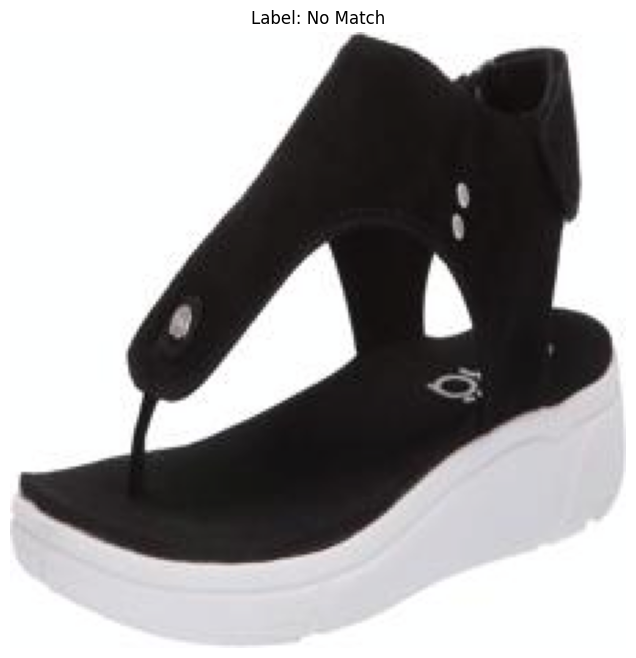

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

def preprocess_for_feature_distillation(train_df, val_df, test_df,
                                      text_column='text_for_deep',
                                      image_column='processed_image_path',
                                      output_dir='distillation_features',
                                      bert_model_name='bert-base-uncased',
                                      max_length=256,
                                      batch_size=32):
    """
    Prepare text and image data for pre-trained feature distillation network.

    Parameters:
    train_df, val_df, test_df: The split datasets
    text_column: Name of the text column
    image_column: Name of the image path column
    output_dir: Directory to save the features
    bert_model_name: The name of the BERT model to use
    max_length: Maximum length of the text
    batch_size: The batch size for data loading
    """
    os.makedirs(output_dir, exist_ok=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print("Preparing data for the pre-trained feature distillation network...")

    # === 1. Prepare BERT Tokenizer ===
    print("\n1. Initialize BERT tokenizer")
    tokenizer = BertTokenizer.from_pretrained(bert_model_name)

    # === 2. Define Image Transforms ===
    print("\n2. Define image transforms")
    # Standard normalization parameters for ResNet pretrained models
    image_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet mean normalization
            std=[0.229, 0.224, 0.225]    # ImageNet std normalization
        )
    ])

    # === 3. Create Dataset Class ===
    class DistillationDataset(Dataset):
        def __init__(self, df, tokenizer, transform, text_column, image_column, max_length):
            self.df = df
            self.tokenizer = tokenizer
            self.transform = transform
            self.text_column = text_column
            self.image_column = image_column
            self.max_length = max_length

            # Record valid indices
            self.valid_indices = []
            for idx, row in tqdm(df.iterrows(), total=len(df), desc="Validating image paths"):
                if pd.notna(row[image_column]) and os.path.exists(row[image_column]):
                    self.valid_indices.append(idx)

            print(f"Valid samples: {len(self.valid_indices)}/{len(df)}")

        def __len__(self):
            return len(self.valid_indices)

        def __getitem__(self, idx):
            orig_idx = self.valid_indices[idx]
            row = self.df.iloc[orig_idx]
            text = row[self.text_column]
            image_path = row[self.image_column]
            label = row['is_match']

            # Process text
            encoding = self.tokenizer(
                text,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            # Flatten the batch dimension
            input_ids = encoding['input_ids'].squeeze()
            attention_mask = encoding['attention_mask'].squeeze()

            # Process image
            try:
                image = Image.open(image_path).convert('RGB')
                image_tensor = self.transform(image)
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")
                # Return a zero tensor as a placeholder
                image_tensor = torch.zeros((3, 224, 224))

            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'image': image_tensor,
                'label': torch.tensor(label, dtype=torch.long),
                'idx': torch.tensor(orig_idx)
            }

    # === 4. Create Datasets ===
    print("\n3. Creating datasets")
    train_dataset = DistillationDataset(
        train_df, tokenizer, image_transforms,
        text_column, image_column, max_length
    )

    val_dataset = DistillationDataset(
        val_df, tokenizer, image_transforms,
        text_column, image_column, max_length
    )

    test_dataset = DistillationDataset(
        test_df, tokenizer, image_transforms,
        text_column, image_column, max_length
    )

    # === 5. Save Dataset Information ===
    print("\n4. Saving dataset information")
    dataset_info = {
        'train_size': len(train_dataset),
        'val_size': len(val_dataset),
        'test_size': len(test_dataset),
        'max_length': max_length,
        'bert_model': bert_model_name
    }

    with open(os.path.join(output_dir, 'dataset_info.json'), 'w') as f:
        json.dump(dataset_info, f)

    # Save valid indices
    np.save(os.path.join(output_dir, 'train_valid_indices.npy'), np.array(train_dataset.valid_indices))
    np.save(os.path.join(output_dir, 'val_valid_indices.npy'), np.array(val_dataset.valid_indices))
    np.save(os.path.join(output_dir, 'test_valid_indices.npy'), np.array(test_dataset.valid_indices))

    # Save valid DataFrames
    train_df_valid = train_df.iloc[train_dataset.valid_indices].copy()
    val_df_valid = val_df.iloc[val_dataset.valid_indices].copy()
    test_df_valid = test_df.iloc[test_dataset.valid_indices].copy()

    train_df_valid.to_csv(os.path.join(output_dir, 'train_df_valid.csv'), index=False)
    val_df_valid.to_csv(os.path.join(output_dir, 'val_df_valid.csv'), index=False)
    test_df_valid.to_csv(os.path.join(output_dir, 'test_df_valid.csv'), index=False)

    # === 6. Create DataLoaders ===
    print("\n5. Creating DataLoaders")
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print("\nData preparation for the pre-trained feature distillation network is complete!")

    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'tokenizer': tokenizer,
        'image_transforms': image_transforms,
        'train_df_valid': train_df_valid,
        'val_df_valid': val_df_valid,
        'test_df_valid': test_df_valid
    }

# Call the preprocessing function of distillation
distillation_data = preprocess_for_feature_distillation(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    text_column='text_for_deep',
    image_column='processed_image_path',
    output_dir='/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/distillation_features',
    bert_model_name='bert-base-uncased',
    max_length=256,
    batch_size=32
)

# Retrieve the preprocessed data loaders and datasets
train_loader = distillation_data['train_loader']
val_loader = distillation_data['val_loader']
test_loader = distillation_data['test_loader']
tokenizer = distillation_data['tokenizer']

# Check the training set size and valid sample information
print(f"Training set size: {len(distillation_data['train_dataset'])} valid samples")
print(f"Validation set size: {len(distillation_data['val_dataset'])} valid samples")
print(f"Test set size: {len(distillation_data['test_dataset'])} valid samples")

# Get a batch from the data loader and check its contents
for batch in train_loader:
    # Print the shape of each component in the batch
    print("\nBatch content shapes:")
    print(f"Input IDs: {batch['input_ids'].shape}")
    print(f"Attention mask: {batch['attention_mask'].shape}")
    print(f"Image: {batch['image'].shape}")
    print(f"Label: {batch['label'].shape}")

    # Visualize the first example in the batch
    # 1. Decode the token IDs to see the text
    input_ids = batch['input_ids'][0].numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    text = tokenizer.convert_tokens_to_string(tokens)
    print(f"\nDecoded text example (truncated):\n{text[:200]}...")

    # 2. Display the image
    img = batch['image'][0].permute(1, 2, 0).numpy()
    # Reverse the normalization of the image for visualization
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Label: {'Match' if batch['label'][0].item() == 1 else 'No Match'}")
    plt.show()

    break

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

def load_distillation_data(output_dir, batch_size=32, num_workers=2):
    """
    This function recreates the distillation_data dictionary by loading saved files
    from the output directory, including dataset information, valid indices, and
    processed DataFrames.

    Parameters:
    -----------
    output_dir : str
        Path to the directory where the distillation files were saved
    batch_size : int, optional
        Batch size for DataLoaders, default is 32
    num_workers : int, optional
        Number of workers for DataLoaders, default is 2

    Returns:
    --------
    dict
        Reconstructed distillation_data dictionary containing:
        - train_loader, val_loader, test_loader: DataLoader objects
        - train_dataset, val_dataset, test_dataset: Dataset objects
        - tokenizer: BERT tokenizer
        - image_transforms: torchvision transforms
        - train_df_valid, val_df_valid, test_df_valid: Filtered DataFrames
    """
    # 1. Load dataset information
    with open(os.path.join(output_dir, 'dataset_info.json'), 'r') as f:
        dataset_info = json.load(f)

    # Extract necessary parameters
    max_length = dataset_info['max_length']
    bert_model_name = dataset_info['bert_model']

    # 2. Load valid indices
    train_valid_indices = np.load(os.path.join(output_dir, 'train_valid_indices.npy'))
    val_valid_indices = np.load(os.path.join(output_dir, 'val_valid_indices.npy'))
    test_valid_indices = np.load(os.path.join(output_dir, 'test_valid_indices.npy'))

    # 3. Load valid DataFrames
    train_df_valid = pd.read_csv(os.path.join(output_dir, 'train_df_valid.csv'))
    val_df_valid = pd.read_csv(os.path.join(output_dir, 'val_df_valid.csv'))
    test_df_valid = pd.read_csv(os.path.join(output_dir, 'test_df_valid.csv'))

    # 4. Reload tokenizer and define image transformations
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained(bert_model_name)

    # Define image transformations (same as in the original code)
    image_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # ImageNet mean normalization
            std=[0.229, 0.224, 0.225]    # ImageNet std normalization
        )
    ])

    # 5. Recreate the dataset class
    class DistillationDataset(Dataset):
        """
        Dataset class for handling text and image data for distillation.

        This class loads text data through BERT tokenizer and image data through
        torchvision transforms, and provides both in a format suitable for
        distillation models.
        """
        def __init__(self, df, tokenizer, transform, text_column, image_column, max_length, valid_indices=None):
            self.df = df
            self.tokenizer = tokenizer
            self.transform = transform
            self.text_column = text_column
            self.image_column = image_column
            self.max_length = max_length

            # If valid indices are provided, use them directly
            if valid_indices is not None:
                self.valid_indices = valid_indices
            else:
                # Otherwise, find valid indices as in the original code
                self.valid_indices = []
                for idx, row in tqdm(df.iterrows(), total=len(df), desc="Validating image paths"):
                    if pd.notna(row[image_column]) and os.path.exists(row[image_column]):
                        self.valid_indices.append(idx)

            print(f"Valid samples: {len(self.valid_indices)}/{len(df)}")

        def __len__(self):
            return len(self.valid_indices)

        def __getitem__(self, idx):
            orig_idx = self.valid_indices[idx]
            row = self.df.iloc[orig_idx]
            text = row[self.text_column]
            image_path = row[self.image_column]
            label = row['is_match']

            # Process text
            encoding = self.tokenizer(
                text,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )

            # Flatten batch dimension
            input_ids = encoding['input_ids'].squeeze()
            attention_mask = encoding['attention_mask'].squeeze()

            # Process image
            try:
                image = Image.open(image_path).convert('RGB')
                image_tensor = self.transform(image)
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")
                # Return a zero tensor as placeholder
                image_tensor = torch.zeros((3, 224, 224))

            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'image': image_tensor,
                'label': torch.tensor(label, dtype=torch.long),
                'idx': torch.tensor(orig_idx)
            }

    # 6. Create datasets using valid indices and DataFrames
    text_column = 'text_for_deep'
    image_column = 'processed_image_path'

    print("\nRecreating datasets...")
    # Since we're using the filtered DataFrames, the indices now range from 0 to len(df)
    train_dataset = DistillationDataset(
        train_df_valid, tokenizer, image_transforms,
        text_column, image_column, max_length, valid_indices=range(len(train_df_valid))
    )

    val_dataset = DistillationDataset(
        val_df_valid, tokenizer, image_transforms,
        text_column, image_column, max_length, valid_indices=range(len(val_df_valid))
    )

    test_dataset = DistillationDataset(
        test_df_valid, tokenizer, image_transforms,
        text_column, image_column, max_length, valid_indices=range(len(test_df_valid))
    )

    # 7. Create DataLoaders
    print("\nCreating DataLoaders...")
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    # 8. Rebuild the distillation_data dictionary
    distillation_data = {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'tokenizer': tokenizer,
        'image_transforms': image_transforms,
        'train_df_valid': train_df_valid,
        'val_df_valid': val_df_valid,
        'test_df_valid': test_df_valid
    }

    print("\nData recovery complete!")
    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Test set size: {len(test_dataset)}")

    return distillation_data

output_dir = '/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/distillation_features'
distillation_data = load_distillation_data(output_dir)

train_loader = distillation_data['train_loader']
val_loader = distillation_data['val_loader']
test_loader = distillation_data['test_loader']
tokenizer = distillation_data['tokenizer']

# Dynamic Sparse Cross-modal Attention Network

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
import os
import json
import re
from tqdm import tqdm

def preprocess_for_sparse_attention(train_df, val_df, test_df,
                                   text_column='text_for_deep',
                                   image_column='processed_image_path',
                                   output_dir='sparse_attention_features',
                                   bert_model_name='bert-base-uncased',
                                   max_length=256,
                                   batch_size=32,
                                   patch_size=16):
    """
    Prepares data for dynamic sparse cross-modal attention network.

    Parameters:
    train_df, val_df, test_df: Pre-split datasets
    text_column: Name of the column containing the deep text data
    image_column: Name of the column containing the image paths
    output_dir: Directory where the preprocessed data will be saved
    bert_model_name: The BERT model name to be used
    max_length: Maximum length for tokenizing the text
    batch_size: Batch size for data loading
    patch_size: Size of the patches for ViT (Vision Transformer)
    """
    os.makedirs(output_dir, exist_ok=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print("Preparing data for dynamic sparse cross-modal attention network...")

    # === 1. Initialize BERT tokenizer ===
    print("\n1. Initializing BERT tokenizer")
    tokenizer = BertTokenizer.from_pretrained(bert_model_name)

    # Add special tokens (if they are not already in the vocabulary)
    special_tokens = ['[TITLE]', '[CAT]', '[FEAT]', '[DESC]', '[DET]']
    special_tokens_dict = {'additional_special_tokens': special_tokens}
    tokenizer.add_special_tokens(special_tokens_dict)

    # === 2. Define Vision Transformer image transformations ===
    print("\n2. Defining Vision Transformer image transformations")
    # ViT typically uses simpler preprocessing and normalization
    image_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # ViT normalization
    ])

    # === 3. Create dataset class ===
    class SparseAttentionDataset(Dataset):
        def __init__(self, df, tokenizer, transform, text_column, image_column, max_length):
            self.df = df
            self.tokenizer = tokenizer
            self.transform = transform
            self.text_column = text_column
            self.image_column = image_column
            self.max_length = max_length

            # Record valid indices
            self.valid_indices = []
            for idx, row in tqdm(df.iterrows(), total=len(df), desc="Validating image paths"):
                if pd.notna(row[image_column]) and os.path.exists(row[image_column]):
                    self.valid_indices.append(idx)

            print(f"Number of valid samples: {len(self.valid_indices)}/{len(df)}")

        def __len__(self):
            return len(self.valid_indices)

        def __getitem__(self, idx):
            orig_idx = self.valid_indices[idx]
            row = self.df.iloc[orig_idx]
            text = row[self.text_column]
            image_path = row[self.image_column]
            label = row['is_match']

            # Process text - structured tokenization
            # Add field type markers to each text section
            field_boundaries = {}

            # Find the positions of field markers
            field_markers = ['[TITLE]', '[CAT]', '[FEAT]', '[DESC]', '[DET]']
            field_positions = {}

            for marker in field_markers:
                pos = text.find(marker)
                if pos != -1:
                    field_positions[marker] = pos

            # Sort the field markers to get the order of fields
            sorted_markers = sorted(field_positions.items(), key=lambda x: x[1])

            # Extract the text for each field
            field_texts = {}
            for i, (marker, pos) in enumerate(sorted_markers):
                start = pos + len(marker)
                if i < len(sorted_markers) - 1:
                    end = sorted_markers[i+1][1]
                else:
                    end = len(text)
                field_texts[marker] = text[start:end].strip()

            # Tokenize each field separately to support field-level attention
            field_encodings = {}
            for marker, field_text in field_texts.items():
                if field_text:  # Only process non-empty fields
                    field_encodings[marker] = self.tokenizer(
                        field_text,
                        max_length=max_length // len(field_texts),  # Distribute tokens evenly
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt'
                    )

            # Merge the tokenized fields, each with its own token_type_id
            merged_input_ids = []
            merged_attention_mask = []
            merged_token_type_ids = []

            field_token_type = 0
            field_boundaries = {}

            for marker in field_markers:
                if marker in field_encodings:
                    # Record the starting position of the field
                    start_pos = len(merged_input_ids)

                    # Get the encoding of the field
                    field_input_ids = field_encodings[marker]['input_ids'].squeeze()
                    field_attention_mask = field_encodings[marker]['attention_mask'].squeeze()

                    # Only add non-padding tokens
                    valid_length = field_attention_mask.sum().item()
                    field_input_ids = field_input_ids[:valid_length]
                    field_attention_mask = field_attention_mask[:valid_length]

                    # Add to the merged lists
                    merged_input_ids.extend(field_input_ids.tolist())
                    merged_attention_mask.extend(field_attention_mask.tolist())

                    # Assign token_type_id for this field
                    merged_token_type_ids.extend([field_token_type] * len(field_input_ids))

                    # Record the ending position of the field
                    end_pos = len(merged_input_ids) - 1
                    field_boundaries[marker.replace('[', '').replace(']', '')] = (start_pos, end_pos)

                    # Next field gets a different token_type_id
                    field_token_type += 1

            # Ensure the total length doesn't exceed max_length
            if len(merged_input_ids) > max_length:
                merged_input_ids = merged_input_ids[:max_length]
                merged_attention_mask = merged_attention_mask[:max_length]
                merged_token_type_ids = merged_token_type_ids[:max_length]

            # If total length is less than max_length, pad to max_length
            padding_length = max_length - len(merged_input_ids)
            if padding_length > 0:
                merged_input_ids.extend([self.tokenizer.pad_token_id] * padding_length)
                merged_attention_mask.extend([0] * padding_length)
                merged_token_type_ids.extend([0] * padding_length)

            # Convert to tensors
            input_ids = torch.tensor(merged_input_ids)
            attention_mask = torch.tensor(merged_attention_mask)
            token_type_ids = torch.tensor(merged_token_type_ids)

            # Process the image (using patches)
            try:
                image = Image.open(image_path).convert('RGB')
                image_tensor = self.transform(image)
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")
                # Return zero tensor as a placeholder
                image_tensor = torch.zeros((3, 224, 224))

            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'token_type_ids': token_type_ids,
                'field_boundaries': field_boundaries,
                'image': image_tensor,
                'label': torch.tensor(label, dtype=torch.long),
                'idx': torch.tensor(orig_idx)
            }

    # === 4. Create datasets ===
    print("\n3. Creating datasets")
    train_dataset = SparseAttentionDataset(
        train_df, tokenizer, image_transforms,
        text_column, image_column, max_length
    )

    val_dataset = SparseAttentionDataset(
        val_df, tokenizer, image_transforms,
        text_column, image_column, max_length
    )

    test_dataset = SparseAttentionDataset(
        test_df, tokenizer, image_transforms,
        text_column, image_column, max_length
    )

    # Custom collate function to handle field_boundaries
    def sparse_attention_collate_fn(batch):
        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])
        token_type_ids = torch.stack([item['token_type_ids'] for item in batch])
        images = torch.stack([item['image'] for item in batch])
        labels = torch.stack([item['label'] for item in batch])
        indices = torch.stack([item['idx'] for item in batch])

        # field_boundaries is a list of dictionaries, cannot simply stack
        field_boundaries = [item['field_boundaries'] for item in batch]

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'field_boundaries': field_boundaries,
            'image': images,
            'label': labels,
            'idx': indices
        }

    # === 5. Create data loaders ===
    print("\n4. Creating data loaders")
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        collate_fn=sparse_attention_collate_fn,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=sparse_attention_collate_fn,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=sparse_attention_collate_fn,
        pin_memory=True if torch.cuda.is_available() else False
    )

    # === 6. Save dataset processing information ===
    print("\n5. Saving dataset information")
    dataset_info = {
        'train_size': len(train_dataset),
        'val_size': len(val_dataset),
        'test_size': len(test_dataset),
        'max_length': max_length,
        'bert_model': bert_model_name,
        'patch_size': patch_size
    }

    with open(os.path.join(output_dir, 'dataset_info.json'), 'w') as f:
        json.dump(dataset_info, f)

    # Save valid indices
    np.save(os.path.join(output_dir, 'train_valid_indices.npy'), np.array(train_dataset.valid_indices))
    np.save(os.path.join(output_dir, 'val_valid_indices.npy'), np.array(val_dataset.valid_indices))
    np.save(os.path.join(output_dir, 'test_valid_indices.npy'), np.array(test_dataset.valid_indices))

    # Save valid DataFrames
    train_df_valid = train_df.iloc[train_dataset.valid_indices].copy()
    val_df_valid = val_df.iloc[val_dataset.valid_indices].copy()
    test_df_valid = test_df.iloc[test_dataset.valid_indices].copy()

    train_df_valid.to_csv(os.path.join(output_dir, 'train_df_valid.csv'), index=False)
    val_df_valid.to_csv(os.path.join(output_dir, 'val_df_valid.csv'), index=False)
    test_df_valid.to_csv(os.path.join(output_dir, 'test_df_valid.csv'), index=False)

    print("\nData preparation for dynamic sparse cross-modal attention network is complete!")

    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'tokenizer': tokenizer,
        'image_transforms': image_transforms,
        'train_df_valid': train_df_valid,
        'val_df_valid': val_df_valid,
        'test_df_valid': test_df_valid
    }


Using device: cuda
Preparing data for dynamic sparse cross-modal attention network...

1. Initializing BERT tokenizer

2. Defining Vision Transformer image transformations

3. Creating datasets


Validating image paths: 100%|██████████| 35923/35923 [00:07<00:00, 5004.73it/s]


Number of valid samples: 35923/35923


Validating image paths: 100%|██████████| 5132/5132 [00:00<00:00, 5241.65it/s]


Number of valid samples: 5132/5132


Validating image paths: 100%|██████████| 10265/10265 [00:01<00:00, 5192.89it/s]


Number of valid samples: 10265/10265

4. Creating data loaders

5. Saving dataset information

Data preparation for dynamic sparse cross-modal attention network is complete!
Training set size: 35923 valid samples
Validation set size: 5132 valid samples
Test set size: 10265 valid samples

Batch content shapes:
Input IDs: torch.Size([16, 256])
Attention Mask: torch.Size([16, 256])
Token Type IDs: torch.Size([16, 256])
Image: torch.Size([16, 3, 224, 224])
Label: torch.Size([16])

Field boundaries for the first sample:
TITLE: 0 to 14
CAT: 15 to 36
FEAT: 37 to 69
DESC: 70 to 75
DET: 76 to 126


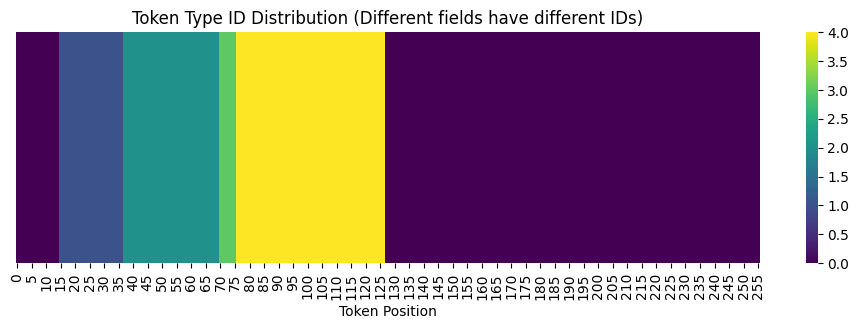

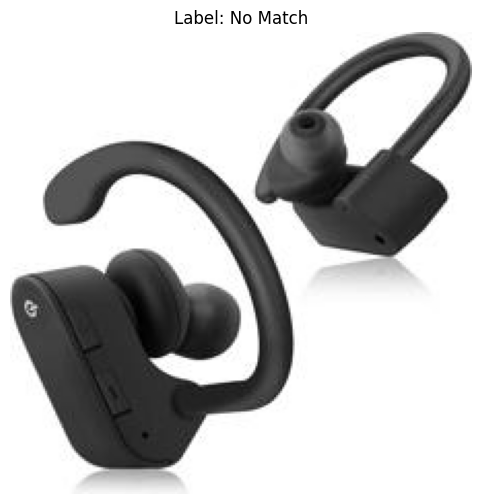

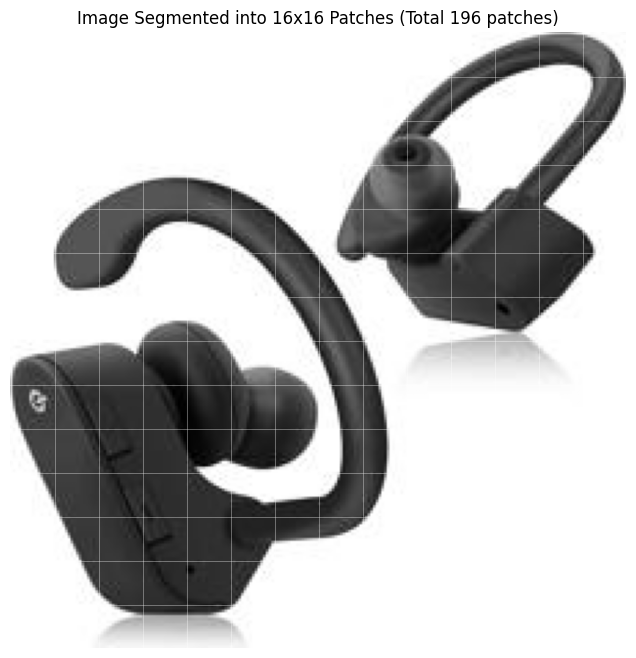


Token Type Distribution Statistics:


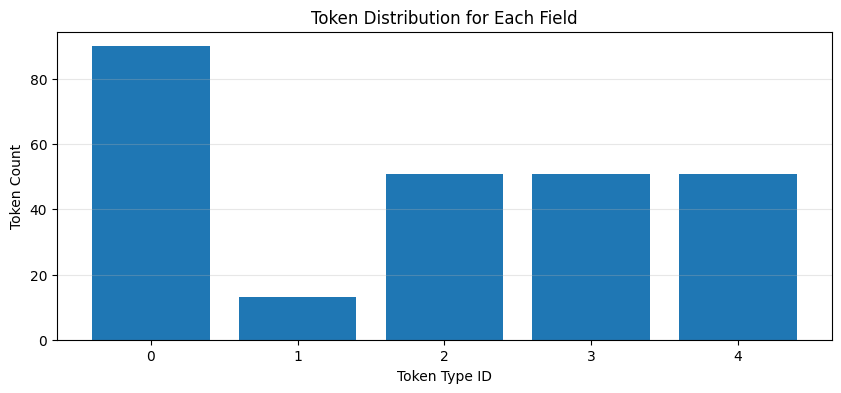

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

# Call the preprocessing function
sparse_attention_data = preprocess_for_sparse_attention(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    text_column='text_for_deep',
    image_column='processed_image_path',
    output_dir='/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/sparse_attention_features',
    bert_model_name='bert-base-uncased',
    max_length=256,
    batch_size=16,
    patch_size=16
)

# Get the returned data loaders and datasets
train_loader = sparse_attention_data['train_loader']
tokenizer = sparse_attention_data['tokenizer']

# Print the dataset sizes
print(f"Training set size: {len(sparse_attention_data['train_dataset'])} valid samples")
print(f"Validation set size: {len(sparse_attention_data['val_dataset'])} valid samples")
print(f"Test set size: {len(sparse_attention_data['test_dataset'])} valid samples")

# Get and check one batch
for batch in train_loader:
    # Print the shapes of components in the batch
    print("\nBatch content shapes:")
    print(f"Input IDs: {batch['input_ids'].shape}")
    print(f"Attention Mask: {batch['attention_mask'].shape}")
    print(f"Token Type IDs: {batch['token_type_ids'].shape}")
    print(f"Image: {batch['image'].shape}")
    print(f"Label: {batch['label'].shape}")

    # Print field boundaries
    print("\nField boundaries for the first sample:")
    for field, (start, end) in batch['field_boundaries'][0].items():
        print(f"{field}: {start} to {end}")

    # Visualize the structure of the first sample
    sample_idx = 0
    input_ids = batch['input_ids'][sample_idx]
    token_types = batch['token_type_ids'][sample_idx]

    # Decode token IDs and check field markers
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Create a simple visualization for token types
    plt.figure(figsize=(12, 3))
    sns.heatmap([token_types.numpy()], cmap='viridis', cbar=True)
    plt.title("Token Type ID Distribution (Different fields have different IDs)")
    plt.xlabel("Token Position")
    plt.yticks([])
    plt.show()

    # Visualize the image
    img = batch['image'][sample_idx].permute(1, 2, 0).numpy()
    # Reverse the normalization to visualize the image
    img = img * 0.5 + 0.5  # Convert from [-1,1] to [0,1] range
    img = np.clip(img, 0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Label: {'Match' if batch['label'][sample_idx].item() == 1 else 'No Match'}")
    plt.show()

    # Check patch visualization
    patch_size = 16
    h, w = 224, 224
    num_patches = (h // patch_size) * (w // patch_size)

    # Create patch grid
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)

    # Add patch grid lines
    for i in range(0, h, patch_size):
        ax.axhline(i, color='white', lw=0.5, alpha=0.5)
    for j in range(0, w, patch_size):
        ax.axvline(j, color='white', lw=0.5, alpha=0.5)

    plt.title(f"Image Segmented into {patch_size}x{patch_size} Patches (Total {num_patches} patches)")
    plt.axis('off')
    plt.show()

    # Exit loop after checking the first batch
    break

# Visualize the distribution of different token types
print("\nToken Type Distribution Statistics:")
token_types_count = {}
for i in range(train_loader.dataset[0]['token_type_ids'].max().item() + 1):
    token_types_count[i] = (train_loader.dataset[0]['token_type_ids'] == i).sum().item()

plt.figure(figsize=(10, 4))
plt.bar(token_types_count.keys(), token_types_count.values())
plt.xlabel('Token Type ID')
plt.ylabel('Token Count')
plt.title('Token Distribution for Each Field')
plt.xticks(list(token_types_count.keys()))
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
import os
import json
from tqdm import tqdm

def load_sparse_attention_data(input_dir='sparse_attention_features', batch_size=None):
    """
    Load data from files generated by the preprocessing function and recreate the sparse attention data structure.

    Parameters:
    input_dir: Directory where the preprocessed data is saved.
    batch_size: The batch size for data loading. If None, the original saved batch size will be used.

    Returns:
    A dictionary containing DataLoader, Dataset, and other objects.
    """
    print(f"Loading sparse attention data from {input_dir}...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # === 1. Load dataset information ===
    print("\n1. Loading dataset information")
    with open(os.path.join(input_dir, 'dataset_info.json'), 'r') as f:
        dataset_info = json.load(f)

    max_length = dataset_info['max_length']
    bert_model_name = dataset_info['bert_model']
    patch_size = dataset_info['patch_size']

    if batch_size is None:
        batch_size = 32  # Default batch size

    # === 2. Load valid indices ===
    print("\n2. Loading valid indices")
    train_valid_indices = np.load(os.path.join(input_dir, 'train_valid_indices.npy'))
    val_valid_indices = np.load(os.path.join(input_dir, 'val_valid_indices.npy'))
    test_valid_indices = np.load(os.path.join(input_dir, 'test_valid_indices.npy'))

    # === 3. Load valid DataFrame ===
    print("\n3. Loading valid DataFrame")
    train_df_valid = pd.read_csv(os.path.join(input_dir, 'train_df_valid.csv'))
    val_df_valid = pd.read_csv(os.path.join(input_dir, 'val_df_valid.csv'))
    test_df_valid = pd.read_csv(os.path.join(input_dir, 'test_df_valid.csv'))

    # === 4. Initialize BERT tokenizer ===
    print("\n4. Initializing BERT tokenizer")
    tokenizer = BertTokenizer.from_pretrained(bert_model_name)

    # Add special tokens
    special_tokens = ['[TITLE]', '[CAT]', '[FEAT]', '[DESC]', '[DET]']
    special_tokens_dict = {'additional_special_tokens': special_tokens}
    tokenizer.add_special_tokens(special_tokens_dict)

    # === 5. Define Vision Transformer image transformations ===
    print("\n5. Defining Vision Transformer image transformations")
    image_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # === 6. Create dataset class ===
    print("\n6. Creating dataset class")
    class SparseAttentionDataset(Dataset):
        def __init__(self, df, tokenizer, transform, valid_indices, max_length,
                     text_column='text_for_deep', image_column='processed_image_path'):
            self.df = df
            self.tokenizer = tokenizer
            self.transform = transform
            self.valid_indices = valid_indices
            self.max_length = max_length
            self.text_column = text_column
            self.image_column = image_column

            print(f"Dataset size: {len(self.valid_indices)}")

        def __len__(self):
            return len(self.valid_indices)

        def __getitem__(self, idx):
            orig_idx = self.valid_indices[idx]
            row = self.df.iloc[idx]  # Since df is already valid_df, we use idx directly
            text = row[self.text_column]
            image_path = row[self.image_column]
            label = row['is_match']

            # Process text - Structured tokenization
            field_boundaries = {}

            # Find the positions of the field markers
            field_markers = ['[TITLE]', '[CAT]', '[FEAT]', '[DESC]', '[DET]']
            field_positions = {}

            for marker in field_markers:
                pos = text.find(marker)
                if pos != -1:
                    field_positions[marker] = pos

            # Sort the field markers by position
            sorted_markers = sorted(field_positions.items(), key=lambda x: x[1])

            # Extract text for each field
            field_texts = {}
            for i, (marker, pos) in enumerate(sorted_markers):
                start = pos + len(marker)
                if i < len(sorted_markers) - 1:
                    end = sorted_markers[i+1][1]
                else:
                    end = len(text)
                field_texts[marker] = text[start:end].strip()

            # Tokenize each field separately for field-level attention
            field_encodings = {}
            for marker, field_text in field_texts.items():
                if field_text:  # Only process non-empty fields
                    field_encodings[marker] = self.tokenizer(
                        field_text,
                        max_length=max_length // len(field_texts),  # Distribute tokens evenly
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt'
                    )

            # Merge the tokenized fields, each field has its own token_type_id
            merged_input_ids = []
            merged_attention_mask = []
            merged_token_type_ids = []

            field_token_type = 0
            field_boundaries = {}

            for marker in field_markers:
                if marker in field_encodings:
                    # Record the start position of the field
                    start_pos = len(merged_input_ids)

                    # Get the encoding for the field
                    field_input_ids = field_encodings[marker]['input_ids'].squeeze()
                    field_attention_mask = field_encodings[marker]['attention_mask'].squeeze()

                    # Only add non-padding tokens
                    valid_length = field_attention_mask.sum().item()
                    field_input_ids = field_input_ids[:valid_length]
                    field_attention_mask = field_attention_mask[:valid_length]

                    # Add to the merged list
                    merged_input_ids.extend(field_input_ids.tolist())
                    merged_attention_mask.extend(field_attention_mask.tolist())

                    # Assign token_type_id for this field
                    merged_token_type_ids.extend([field_token_type] * len(field_input_ids))

                    # Record the end position of the field
                    end_pos = len(merged_input_ids) - 1
                    field_boundaries[marker.replace('[', '').replace(']', '')] = (start_pos, end_pos)

                    # The next field gets a different token_type_id
                    field_token_type += 1

            # Ensure the total length doesn't exceed max_length
            if len(merged_input_ids) > max_length:
                merged_input_ids = merged_input_ids[:max_length]
                merged_attention_mask = merged_attention_mask[:max_length]
                merged_token_type_ids = merged_token_type_ids[:max_length]

            # If the total length is less than max_length, pad to max_length
            padding_length = max_length - len(merged_input_ids)
            if padding_length > 0:
                merged_input_ids.extend([self.tokenizer.pad_token_id] * padding_length)
                merged_attention_mask.extend([0] * padding_length)
                merged_token_type_ids.extend([0] * padding_length)

            # Convert to tensors
            input_ids = torch.tensor(merged_input_ids)
            attention_mask = torch.tensor(merged_attention_mask)
            token_type_ids = torch.tensor(merged_token_type_ids)

            # Process image (using patches)
            try:
                image = Image.open(image_path).convert('RGB')
                image_tensor = self.transform(image)
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")
                # Return a zero tensor as a placeholder
                image_tensor = torch.zeros((3, 224, 224))

            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'token_type_ids': token_type_ids,
                'field_boundaries': field_boundaries,
                'image': image_tensor,
                'label': torch.tensor(label, dtype=torch.long),
                'idx': torch.tensor(idx)
            }

    # === 7. Create datasets ===
    print("\n7. Creating datasets")
    train_dataset = SparseAttentionDataset(
        train_df_valid, tokenizer, image_transforms,
        train_valid_indices, max_length
    )

    val_dataset = SparseAttentionDataset(
        val_df_valid, tokenizer, image_transforms,
        val_valid_indices, max_length
    )

    test_dataset = SparseAttentionDataset(
        test_df_valid, tokenizer, image_transforms,
        test_valid_indices, max_length
    )

    # Custom collate function to handle field_boundaries
    def sparse_attention_collate_fn(batch):
        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])
        token_type_ids = torch.stack([item['token_type_ids'] for item in batch])
        images = torch.stack([item['image'] for item in batch])
        labels = torch.stack([item['label'] for item in batch])
        indices = torch.stack([item['idx'] for item in batch])

        # field_boundaries is a list of dictionaries, cannot be simply stacked
        field_boundaries = [item['field_boundaries'] for item in batch]

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'field_boundaries': field_boundaries,
            'image': images,
            'label': labels,
            'idx': indices
        }

    # === 8. Create data loaders ===
    print("\n8. Creating data loaders")
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        collate_fn=sparse_attention_collate_fn,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=sparse_attention_collate_fn,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=sparse_attention_collate_fn,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print("\nSparse attention data loading complete!")

    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'tokenizer': tokenizer,
        'image_transforms': image_transforms,
        'train_df_valid': train_df_valid,
        'val_df_valid': val_df_valid,
        'test_df_valid': test_df_valid,
        'dataset_info': dataset_info
    }

# Call the preprocessing function
sparse_attention_data = preprocess_for_sparse_attention(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    text_column='text_for_deep',
    image_column='processed_image_path',
    output_dir='/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/sparse_attention_features',
    bert_model_name='bert-base-uncased',
    max_length=256,
    batch_size=16,
    patch_size=16
)

# Get the returned data loaders and datasets
train_loader = sparse_attention_data['train_loader']
val_loader = data_dict['val_loader']
test_loader = data_dict['test_loader']
tokenizer = sparse_attention_data['tokenizer']

# Print the dataset sizes
print(f"Training set size: {len(sparse_attention_data['train_dataset'])} valid samples")
print(f"Validation set size: {len(sparse_attention_data['val_dataset'])} valid samples")
print(f"Test set size: {len(sparse_attention_data['test_dataset'])} valid samples")

# CLIP

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1cy_346e
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-1cy_346e
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
import os
import json
from tqdm import tqdm
import clip

def preprocess_for_clip(train_df, val_df, test_df,
                       text_column='text_for_deep',
                       image_column='processed_image_path',
                       output_dir='clip_features',
                       clip_model_name="ViT-B/16",
                       batch_size=16):
    """
    Prepare text and image data for CLIP model

    Parameters:
    train_df, val_df, test_df: Pre-split datasets
    text_column: Column name for text data
    image_column: Column name for image paths
    output_dir: Directory to save the features
    clip_model_name: Name of the CLIP model to use (ViT-B/32, ViT-B/16, RN50, RN101, etc.)
    batch_size: Batch size for processing
    """
    os.makedirs(output_dir, exist_ok=True)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print(f"Preparing data for CLIP ({clip_model_name}) model...")

    # === 1. Load CLIP model and preprocessors ===
    print("\n1. Loading CLIP model and preprocessor")
    model, preprocess = clip.load(clip_model_name, device=device)

    # Extract tokenizer for text processing
    tokenizer = lambda text: clip.tokenize(text, truncate=True)

    # === 2. Create dataset class ===
    class CLIPDataset(Dataset):
        def __init__(self, df, preprocess, tokenizer, text_column, image_column):
            self.df = df
            self.preprocess = preprocess
            self.tokenizer = tokenizer
            self.text_column = text_column
            self.image_column = image_column

            # Record valid indices
            self.valid_indices = []
            for idx, row in tqdm(df.iterrows(), total=len(df), desc="Validating image paths"):
                if pd.notna(row[image_column]) and os.path.exists(row[image_column]):
                    self.valid_indices.append(idx)

            print(f"Valid samples: {len(self.valid_indices)}/{len(df)}")

        def __len__(self):
            return len(self.valid_indices)

        def __getitem__(self, idx):
            orig_idx = self.valid_indices[idx]
            row = self.df.iloc[orig_idx]
            text = row[self.text_column]
            image_path = row[self.image_column]
            label = row['is_match']

            # Process text - use CLIP's tokenizer
            # Note: Actual tokenization will happen during batching; here, we return the raw text
            text_for_tokenization = text

            # Process image - use CLIP's preprocessor
            try:
                image = Image.open(image_path).convert('RGB')
                image_tensor = self.preprocess(image)
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")
                # Return a zero tensor as a placeholder
                image_tensor = torch.zeros((3, 224, 224))

            return {
                'text': text_for_tokenization,
                'image': image_tensor,
                'label': torch.tensor(label, dtype=torch.long),
                'idx': torch.tensor(orig_idx)
            }

    # === 3. Create datasets ===
    print("\n2. Creating datasets")
    train_dataset = CLIPDataset(
        train_df, preprocess, tokenizer,
        text_column, image_column
    )

    val_dataset = CLIPDataset(
        val_df, preprocess, tokenizer,
        text_column, image_column
    )

    test_dataset = CLIPDataset(
        test_df, preprocess, tokenizer,
        text_column, image_column
    )

    # Custom collate function to handle CLIP's batching
    def clip_collate_fn(batch):
        texts = [item['text'] for item in batch]
        images = torch.stack([item['image'] for item in batch])
        labels = torch.stack([item['label'] for item in batch])
        indices = torch.stack([item['idx'] for item in batch])

        # Tokenize text in batches
        text_tokens = tokenizer(texts)

        return {
            'text': texts,          # Raw text for debugging and visualization
            'text_tokens': text_tokens,  # Tokenized text
            'image': images,
            'label': labels,
            'idx': indices
        }

    # === 4. Create data loaders ===
    print("\n3. Creating data loaders")
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        collate_fn=clip_collate_fn,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=clip_collate_fn,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=clip_collate_fn,
        pin_memory=True if torch.cuda.is_available() else False
    )

    # === 5. Save dataset processing information ===
    print("\n4. Saving dataset information")
    dataset_info = {
        'train_size': len(train_dataset),
        'val_size': len(val_dataset),
        'test_size': len(test_dataset),
        'clip_model': clip_model_name,
    }

    with open(os.path.join(output_dir, 'dataset_info.json'), 'w') as f:
        json.dump(dataset_info, f)

    # Save valid indices
    np.save(os.path.join(output_dir, 'train_valid_indices.npy'), np.array(train_dataset.valid_indices))
    np.save(os.path.join(output_dir, 'val_valid_indices.npy'), np.array(val_dataset.valid_indices))
    np.save(os.path.join(output_dir, 'test_valid_indices.npy'), np.array(test_dataset.valid_indices))

    # Save valid DataFrames
    train_df_valid = train_df.iloc[train_dataset.valid_indices].copy()
    val_df_valid = val_df.iloc[val_dataset.valid_indices].copy()
    test_df_valid = test_df.iloc[test_dataset.valid_indices].copy()

    train_df_valid.to_csv(os.path.join(output_dir, 'train_df_valid.csv'), index=False)
    val_df_valid.to_csv(os.path.join(output_dir, 'val_df_valid.csv'), index=False)
    test_df_valid.to_csv(os.path.join(output_dir, 'test_df_valid.csv'), index=False)

    print("\nCLIP model data preparation complete!")

    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'model': model,
        'preprocess': preprocess,
        'tokenizer': tokenizer,
        'train_df_valid': train_df_valid,
        'val_df_valid': val_df_valid,
        'test_df_valid': test_df_valid
    }

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import clip

clip_data = preprocess_for_clip(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    text_column='text_for_deep',
    image_column='processed_image_path',
    output_dir='/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/clip_features',
    clip_model_name="ViT-B/16",  # Optional: "ViT-B/32", "RN50", "RN101"
    batch_size=16
)

# Print the dataset sizes
print(f"Training set size: {len(clip_data['train_dataset'])} valid samples")
print(f"Validation set size: {len(clip_data['val_dataset'])} valid samples")
print(f"Test set size: {len(clip_data['test_dataset'])} valid samples")

Using device: cuda
Preparing data for CLIP (ViT-B/16) model...

1. Loading CLIP model and preprocessor


100%|███████████████████████████████████████| 335M/335M [00:05<00:00, 59.5MiB/s]



2. Creating datasets


Validating image paths: 100%|██████████| 35923/35923 [00:08<00:00, 3997.85it/s]


Valid samples: 35923/35923


Validating image paths: 100%|██████████| 5132/5132 [00:01<00:00, 3276.19it/s]


Valid samples: 5132/5132


Validating image paths: 100%|██████████| 10265/10265 [00:02<00:00, 4861.48it/s]


Valid samples: 10265/10265

3. Creating data loaders

4. Saving dataset information

CLIP model data preparation complete!
Training set size: 35923 valid samples
Validation set size: 5132 valid samples
Test set size: 10265 valid samples


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import pandas as pd
import os
import json
import clip

def load_clip_data(output_dir='clip_features',
                  text_column='text_for_deep',
                  image_column='processed_image_path',
                  clip_model_name='ViT-B/16',
                  batch_size=16):
    """
    Load CLIP preprocessed data from saved files and rebuild the data loaders

    Parameters:
    output_dir: Directory where preprocessed features are saved
    text_column: Column name for text data
    image_column: Column name for image paths
    clip_model_name: Name of the CLIP model, if None, it will be loaded from dataset_info.json
    batch_size: Batch size for data loading

    Returns:
    dict: Dictionary containing rebuilt data loaders and datasets
    """
    # Check if the output directory exists
    if not os.path.exists(output_dir):
        raise FileNotFoundError(f"Directory not found: {output_dir}")

    # Load dataset information
    with open(os.path.join(output_dir, 'dataset_info.json'), 'r') as f:
        dataset_info = json.load(f)

    # If clip model name is not provided, load it from dataset_info
    if clip_model_name is None:
        clip_model_name = dataset_info['clip_model']

    # Load the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load the CLIP model and preprocessor
    print(f"\n1. Loading CLIP model ({clip_model_name}) and preprocessor")
    model, preprocess = clip.load(clip_model_name, device=device)

    # Extract tokenizer for text processing
    tokenizer = lambda text: clip.tokenize(text, truncate=True)

    # Load valid DataFrames
    print("\n2. Loading valid DataFrames")
    train_df_valid = pd.read_csv(os.path.join(output_dir, 'train_df_valid.csv'))
    val_df_valid = pd.read_csv(os.path.join(output_dir, 'val_df_valid.csv'))
    test_df_valid = pd.read_csv(os.path.join(output_dir, 'test_df_valid.csv'))

    # Define the CLIPDataset class
    class CLIPDataset(Dataset):
        def __init__(self, df, preprocess, tokenizer, text_column=text_column, image_column=image_column):
            self.df = df
            self.preprocess = preprocess
            self.tokenizer = tokenizer
            self.text_column = text_column
            self.image_column = image_column

        def __len__(self):
            return len(self.df)

        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            text = row[self.text_column]
            image_path = row[self.image_column]
            label = row['is_match']

            # Process text - use CLIP's tokenizer
            # Note: Actual tokenization will occur during batching; here we return raw text
            text_for_tokenization = text

            # Process image - use CLIP's preprocessor
            try:
                image = Image.open(image_path).convert('RGB')
                image_tensor = self.preprocess(image)
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")
                # Return a zero tensor as a placeholder
                image_tensor = torch.zeros((3, 224, 224))

            return {
                'text': text_for_tokenization,
                'image': image_tensor,
                'label': torch.tensor(label, dtype=torch.long),
                'idx': torch.tensor(idx)
            }

    # Create datasets
    print("\n3. Creating datasets")
    train_dataset = CLIPDataset(train_df_valid, preprocess, tokenizer)
    val_dataset = CLIPDataset(val_df_valid, preprocess, tokenizer)
    test_dataset = CLIPDataset(test_df_valid, preprocess, tokenizer)

    # Custom collate function to handle CLIP's batching
    def clip_collate_fn(batch):
        texts = [item['text'] for item in batch]
        images = torch.stack([item['image'] for item in batch])
        labels = torch.stack([item['label'] for item in batch])
        indices = torch.stack([item['idx'] for item in batch])

        # Batch tokenize text
        text_tokens = tokenizer(texts)

        return {
            'text': texts,          # Raw text for debugging and visualization
            'text_tokens': text_tokens,  # Tokenized text
            'image': images,
            'label': labels,
            'idx': indices
        }

    # Create data loaders
    print("\n4. Creating data loaders")
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        collate_fn=clip_collate_fn,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=clip_collate_fn,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=clip_collate_fn,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print("\nCLIP data loading complete!")

    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'model': model,
        'preprocess': preprocess,
        'tokenizer': tokenizer,
        'train_df_valid': train_df_valid,
        'val_df_valid': val_df_valid,
        'test_df_valid': test_df_valid
    }

clip_data = load_clip_data(output_dir='/content/drive/MyDrive/GitHub_Repos/CS610-Product-Image-Text-Consistency-Detection-System-for-E-commerce/amazon_meta_data/clip_features',
                  text_column='text_for_deep',
                  image_column='processed_image_path',
                  clip_model_name='ViT-B/16',
                  batch_size=16)

# Get data loaders
train_loader = clip_data['train_loader']
val_loader = clip_data['val_loader']
test_loader = clip_data['test_loader']

# Get the model and preprocessor
model = clip_data['model']
preprocess = clip_data['preprocess']